In [1]:
ventas = r'C:\Users\Usuario\OneDrive\Escritorio\VentasPR.xlsx'
productos = r'C:\Users\Usuario\OneDrive\Escritorio\Producto-UM.xls'
promoción = r'C:\Users\Usuario\OneDrive\Escritorio\Producto-en-Promoción-UM.xls'

In [2]:
import pandas as
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import seaborn as sns
import sweetviz as sv
import ipywidgets as widgets
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from pandas.plotting import autocorrelation_plot
from dateutil.parser import parse
from sklearn.model_selection import cross_val_score, KFold
from IPython.display import display

In [3]:
ventas = pd.read_excel('VentasPR.xlsx', engine='openpyxl')

(ventas.head())

,LOCCOD,MOVFEC,PRDCODEXT,ACPRCANTVEND,ACPRIMPVEN
0,5201,2/5/2021,600790,7,1393
1,5201,2/5/2021,600793,2,390
2,5201,2/5/2021,600794,7,2023
3,5201,2/5/2021,605089,1,399
4,5201,2/5/2021,605097,1,565


In [4]:
(ventas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145276 entries, 0 to 145275
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   LOCCOD        145276 non-null  int64 
 1   MOVFEC        145276 non-null  object
 2   PRDCODEXT     145276 non-null  int64 
 3   ACPRCANTVEND  145276 non-null  int64 
 4   ACPRIMPVEN    145276 non-null  object
dtypes: int64(3), object(2)
memory usage: 5.5+ MB


In [5]:
(ventas.describe())

,LOCCOD,PRDCODEXT,ACPRCANTVEND
count,145276.0,145276.000000,145276.000000
mean,5201.0,571156.444809,3.884702
std,0.0,18674.468358,11.035535
min,5201.0,306252.000000,-152.000000
25%,5201.0,561244.000000,1.000000
50%,5201.0,562230.000000,1.000000
75%,5201.0,562799.000000,3.000000
max,5201.0,660998.000000,678.000000


In [6]:
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], dayfirst=True, errors='coerce')
ventas['ACPRIMPVEN'] = pd.to_numeric(ventas['ACPRIMPVEN'].astype(str).str.replace(',', ''), errors='coerce')

ventas = ventas.dropna(subset=['MOVFEC', 'ACPRIMPVEN']).fillna(0)
ventas = ventas.drop_duplicates(subset=['LOCCOD', 'MOVFEC', 'PRDCODEXT'])

In [7]:
ventas.to_csv('VentasPR_limpio.csv', index=False)
ventas = pd.read_csv('VentasPR_limpio.csv')
# Resumen estadístico de ventas diarias por SKU (producto)
ventas_por_sku = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].describe()

(ventas_por_sku)

,count,mean,std,min,25%,50%,75%,max
PRDCODEXT,,,,,,,,
306252,24.0,45.916667,22.981877,1.0,39.0,46.0,58.50,83.0
540001,115.0,8.730435,9.817923,1.0,2.0,5.0,11.00,42.0
540660,183.0,7.316940,12.296166,1.0,1.0,2.0,8.00,71.0
542168,50.0,1.820000,1.240309,1.0,1.0,1.0,2.00,6.0
542169,89.0,1.842697,2.099236,0.0,1.0,1.0,2.00,14.0
...,...,...,...,...,...,...,...,...
660994,134.0,1.291045,0.669694,-2.0,1.0,1.0,1.75,4.0
660995,115.0,4.086957,6.476090,0.0,1.0,1.0,4.50,43.0
660996,77.0,1.103896,0.446755,1.0,1.0,1.0,1.00,4.0


In [8]:
productos = pd.read_excel('Producto-UM.xls', engine='xlrd')

In [9]:
(productos.head())

,Cod,Status Hoy,Prov,Cat,Tipo Prov
0,561699,5,68952,216,1
1,561634,5,68952,216,1
2,561694,5,68952,216,1
3,561826,5,68952,216,1
4,561891,5,68952,216,1


In [10]:
(productos.tail(500))


,Cod,Status Hoy,Prov,Cat,Tipo Prov
1584,562865,5,64124,216,1
1585,562864,1,64124,216,1
1586,600045,1,64124,216,1
1587,560707,5,67149,217,1
1588,560985,5,67149,217,1
...,...,...,...,...,...
2079,562769,5,66468,216,1
2080,562771,5,66468,216,1
2081,562772,5,66468,216,1
2082,562774,5,66468,216,1


In [11]:
(productos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Cod         2084 non-null   int64
 1   Status Hoy  2084 non-null   int64
 2   Prov        2084 non-null   int64
 3   Cat         2084 non-null   int64
 4   Tipo Prov   2084 non-null   int64
dtypes: int64(5)
memory usage: 81.5 KB


In [12]:
(productos.describe())

,Cod,Status Hoy,Prov,Cat,Tipo Prov
count,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000
mean,570349.047025,2.871401,33164.924184,216.121401,1.009597
std,20415.749692,1.995378,24854.299442,0.326671,0.138242
min,306252.000000,1.000000,10067.000000,216.000000,1.000000
25%,561508.750000,1.000000,11092.000000,216.000000,1.000000
50%,562256.500000,1.000000,22049.000000,216.000000,1.000000
75%,562892.250000,5.000000,64156.000000,216.000000,1.000000
max,974020.000000,5.000000,85300.000000,217.000000,3.000000


In [13]:
(productos.columns)

Index(['Cod', 'Status Hoy', 'Prov', 'Cat', 'Tipo Prov'], dtype='object')

In [14]:
promoción = pd.read_excel('Producto-en-Promoción-UM.xls', engine='xlrd')

In [15]:
(promoción.head())

,PRDCODEXT,PROMDEFFECDES,PROMDEFFECHAS
0,560226,2023-02-13,2023-02-26
1,560227,2023-02-13,2023-02-26
2,561875,2023-02-13,2023-02-26
3,561895,2023-02-13,2023-02-26
4,561899,2023-02-13,2023-02-26


In [16]:
(promoción.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PRDCODEXT      1694 non-null   int64         
 1   PROMDEFFECDES  1694 non-null   datetime64[ns]
 2   PROMDEFFECHAS  1694 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 39.8 KB


In [18]:
(promoción.describe())

,PRDCODEXT,PROMDEFFECDES,PROMDEFFECHAS
count,1694.000000,1694,1694
mean,569348.210153,2022-10-29 04:54:07.225501696,2022-12-07 22:26:29.610389760
min,542171.000000,2021-05-17 00:00:00,2021-05-30 00:00:00
25%,561182.000000,2021-11-04 00:00:00,2021-12-31 00:00:00
50%,562219.000000,2023-02-01 00:00:00,2023-02-26 00:00:00
75%,562730.000000,2023-05-24 00:00:00,2023-06-12 00:00:00
max,660995.000000,2024-04-08 00:00:00,2024-04-28 00:00:00
std,16638.093174,NaN,NaN


In [18]:
# Creo reporte de análisis exploratorio de las bases con Sweetviz

# Cargar los archivos Excel
ventas = pd.read_excel("VentasPR.xlsx")
productos = pd.read_excel("Producto-UM.xls")
promoción = pd.read_excel("Producto-en-Promoción-UM.xls")

# Analizar individualmente
reporte_ventas = sv.analyze(ventas)
reporte_productos = sv.analyze(productos)
reporte_promoción = sv.analyze(promoción)

# Mostrar los informes
reporte_ventas.show_html("reporte_ventas.html")
reporte_productos.show_html("reporte_productos.html")
reporte_promoción.show_html("reporte_promoción.html")

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

Report reporte_ventas.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report reporte_productos.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report reporte_promoción.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [19]:
# Convertir la columna de fechas a tipo datetime
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'])
promoción['PROMDEFFECDES'] = pd.to_datetime(promoción['PROMDEFFECDES'])
promoción['PROMDEFFECHAS'] = pd.to_datetime(promoción['PROMDEFFECHAS'])

In [20]:
# Filtrar ventas de los últimos 3 años
hoy = datetime.now()
fecha_inicio = hoy - timedelta(days=365*3)

# Filtrar ventas
ventas_filtradas = ventas[
    (ventas['MOVFEC'] >= fecha_inicio) &
    (ventas['MOVFEC'] <= hoy) &
    (ventas['PRDCODEXT'].isin(productos[productos['Status Hoy'] == 1]['Cod']))  # Solo productos activos
]

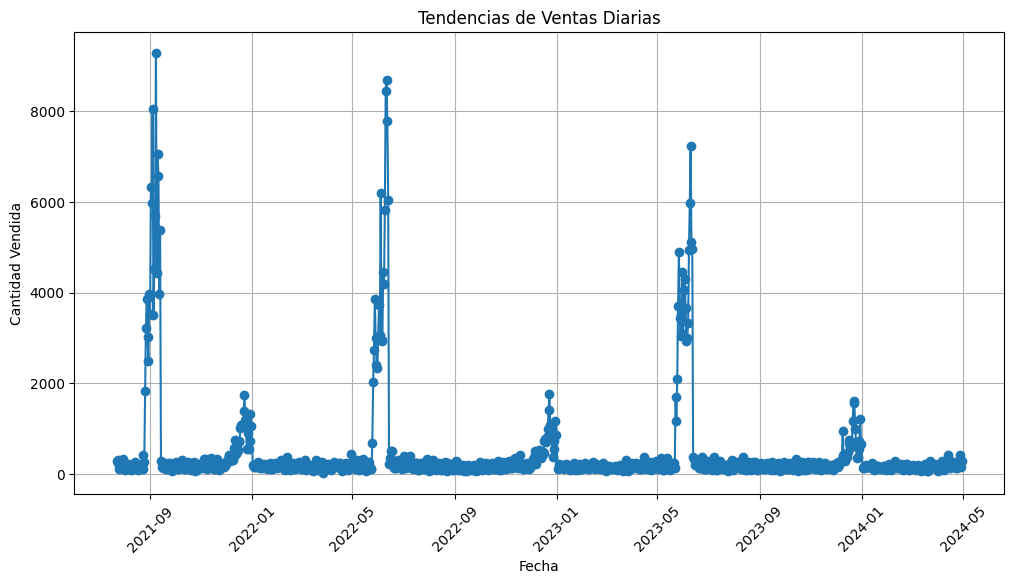

In [21]:
# Visualizar tendencias de ventas
ventas_diarias = ventas_filtradas.groupby('MOVFEC')['ACPRCANTVEND'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(ventas_diarias['MOVFEC'], ventas_diarias['ACPRCANTVEND'], marker='o', linestyle='-')
plt.title('Tendencias de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

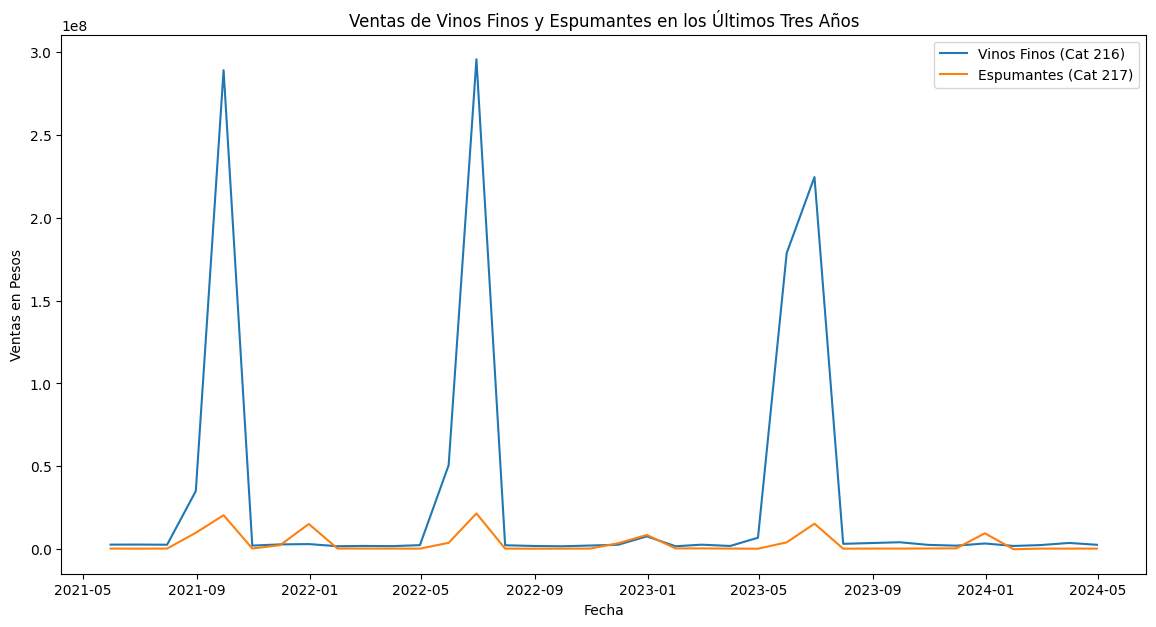

In [22]:
# Convertir columnas de ventas a float
ventas['ACPRIMPVEN'] = ventas['ACPRIMPVEN'].astype(float)

# Filtrar productos por categorías Vinos Finos y Espumantes
productos_vinos = productos[(productos['Cat'] == 216) | (productos['Cat'] == 217)]

# Fusionar ventas con productos para obtener las categorías
ventas_productos = ventas.merge(productos_vinos, left_on='PRDCODEXT', right_on='Cod', how='inner')

# Filtrar las ventas de los últimos tres años
fecha_limite = ventas_productos['MOVFEC'].max() - pd.DateOffset(years=3)
ventas_ultimos_tres_anios = ventas_productos[ventas_productos['MOVFEC'] >= fecha_limite]

# Filtrar por categorías
ventas_vinos_finos = ventas_ultimos_tres_anios[ventas_ultimos_tres_anios['Cat'] == 216]
ventas_espumantes = ventas_ultimos_tres_anios[ventas_ultimos_tres_anios['Cat'] == 217]

# Agrupar las ventas por mes para cada categoría
ventas_vinos_finos_mes = ventas_vinos_finos.resample('M', on='MOVFEC').sum()
ventas_espumantes_mes = ventas_espumantes.resample('M', on='MOVFEC').sum()

# Graficar las ventas
plt.figure(figsize=(14, 7))
plt.plot(ventas_vinos_finos_mes.index, ventas_vinos_finos_mes['ACPRIMPVEN'], label='Vinos Finos (Cat 216)')
plt.plot(ventas_espumantes_mes.index, ventas_espumantes_mes['ACPRIMPVEN'], label='Espumantes (Cat 217)')
plt.title('Ventas de Vinos Finos y Espumantes en los Últimos Tres Años')
plt.xlabel('Fecha')
plt.ylabel('Ventas en Pesos')
plt.legend()
plt.show()


In [23]:
# DF ventas mensuales
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], dayfirst=True, errors='coerce')

# Eliminar filas con fechas inválidas (NaT)
ventas = ventas.dropna(subset=['MOVFEC'])

# Agrupar por producto y mes
ventas_mensuales = ventas.groupby(['PRDCODEXT', pd.Grouper(key='MOVFEC', freq='M')])['ACPRCANTVEND'].sum().reset_index()

# Filtrar para obtener solo la última fecha de cada mes para cada producto
ventas_mensuales_filtrado = ventas_mensuales.sort_values(['PRDCODEXT', 'MOVFEC']).groupby(['PRDCODEXT', pd.Grouper(key='MOVFEC', freq='M')]).last().reset_index()
ventas_mensuales_filtrado.rename(columns = {'ACPRCANTVEND':'VENTAS_MENSUALES'}, inplace = True)

# Ordenar por la máxima cantidad de ventas mensuales por producto
ventas_mensuales_ordenado = ventas_mensuales_filtrado.sort_values(by='VENTAS_MENSUALES', ascending=False)

# Mostrar el resultado ordenado
print("Ventas Mensuales Ordenadas por la Máxima Cantidad:")
print(ventas_mensuales_ordenado.head().to_markdown(index=False, numalign="left", stralign="left"))

Ventas Mensuales Ordenadas por la Máxima Cantidad:
| PRDCODEXT   | MOVFEC              | VENTAS_MENSUALES   |
|:------------|:--------------------|:-------------------|
| 560978      | 2021-09-30 00:00:00 | 5020               |
| 560978      | 2022-06-30 00:00:00 | 2173               |
| 561395      | 2021-09-30 00:00:00 | 1946               |
| 560779      | 2023-06-30 00:00:00 | 1648               |
| 561278      | 2021-09-30 00:00:00 | 1612               |


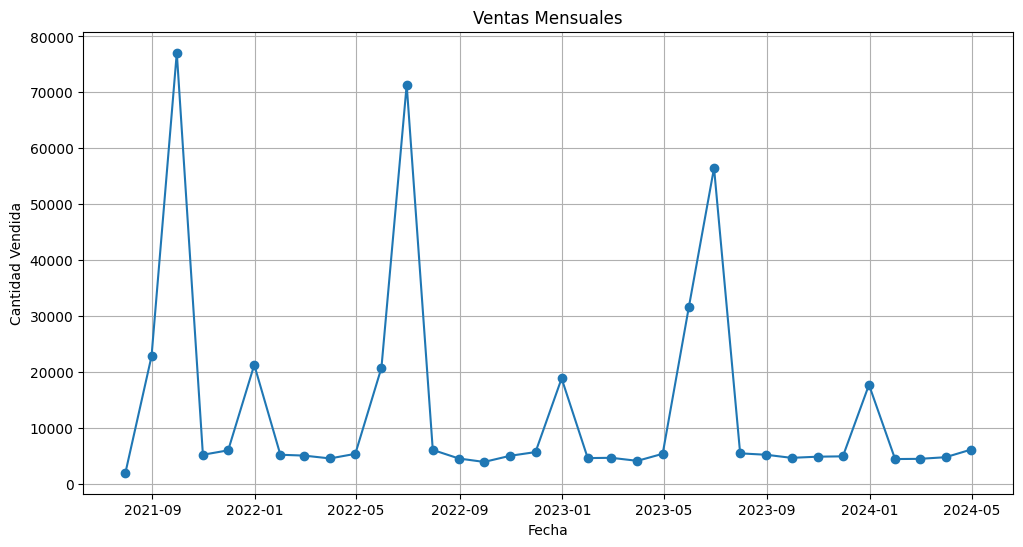

In [24]:
# Columna MOVFEC en formato datetime
ventas_diarias['MOVFEC'] = pd.to_datetime(ventas_diarias['MOVFEC'])

# Establece la columna MOVFEC como índice y resamplea para obtener las ventas mensuales
ventas_mensuales = ventas_diarias.set_index('MOVFEC').resample('M').sum()

# Visualización de la serie temporal de ventas mensuales
plt.figure(figsize=(12, 6))
plt.plot(ventas_mensuales.index, ventas_mensuales['ACPRCANTVEND'], marker='o', linestyle='-')
plt.title('Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.grid(True)
plt.show()

In [25]:
# DF de ventas anuales
# Agrupar por producto y año
ventas_anuales = ventas.groupby(['PRDCODEXT', pd.Grouper(key='MOVFEC', freq='Y')])['ACPRCANTVEND'].sum().reset_index()

# Filtrar para obtener solo la última fecha de cada año para cada producto
ventas_anuales_filtrado = ventas_anuales.sort_values(['PRDCODEXT', 'MOVFEC']).groupby('PRDCODEXT').last().reset_index()
ventas_anuales_filtrado.rename(columns = {'ACPRCANTVEND':'VENTAS_ANUALES'}, inplace = True)

# Ordenar por la máxima cantidad de ventas anuales por producto
ventas_anuales_ordenado = ventas_anuales_filtrado.sort_values(by='VENTAS_ANUALES', ascending=False)

# Mostrar el resultado ordenado
print("Ventas Anuales Ordenadas por la Máxima Cantidad:")
print(ventas_anuales_ordenado.head().to_markdown(index=False, numalign="left", stralign="left"))

Ventas Anuales Ordenadas por la Máxima Cantidad:
| PRDCODEXT   | MOVFEC              | VENTAS_ANUALES   |
|:------------|:--------------------|:-----------------|
| 306252      | 2023-12-31 00:00:00 | 1102             |
| 560779      | 2024-12-31 00:00:00 | 651              |
| 607467      | 2024-12-31 00:00:00 | 525              |
| 562294      | 2023-12-31 00:00:00 | 499              |
| 561557      | 2023-12-31 00:00:00 | 476              |


In [26]:
promoción.columns = promoción.columns.str.strip()
promoción['PROMDEFFECDES'] = pd.to_datetime(promoción['PROMDEFFECDES'])
promoción['PROMDEFFECHAS'] = pd.to_datetime(promoción['PROMDEFFECHAS'])

In [27]:
# Eliminar filas con fechas inválidas (NaT)
ventas = ventas.dropna(subset=['MOVFEC'])

# Filtrar ventas por categoría, últimos 3 años y productos NO congelados
ventas_filtradas = ventas[
    (ventas['PRDCODEXT'].isin(productos[productos['Cat'].isin([216, 217])]['Cod'])) &
    (ventas['MOVFEC'] >= (pd.to_datetime('today') - pd.DateOffset(years=3))) &
    (ventas['PRDCODEXT'].isin(productos[productos['Status Hoy'] == 1]['Cod']))
]

# Unir tablas, manteniendo TODAS las ventas (incluso si no hay info de producto/promo)
ventas_completas = (
    ventas_filtradas
    .merge(productos, left_on='PRDCODEXT', right_on='Cod', how='left')
    .merge(promoción, on='PRDCODEXT', how='left')
)

# Crear flag de promoción
ventas_completas['flag_promocion'] = (
    (ventas_completas['MOVFEC'] >= ventas_completas['PROMDEFFECDES']) &
    (ventas_completas['MOVFEC'] <= ventas_completas['PROMDEFFECHAS'])
).fillna(0).astype(int)  # 0 si NO hay promoción, 1 si SÍ

# Agrupar por SKU, fecha y local, y calcular ventas diarias
ventas_diarias = ventas_completas.groupby(['PRDCODEXT', 'MOVFEC', 'LOCCOD']).agg(
    cantidad_vendida=('ACPRCANTVEND', 'sum'),
    facturacion=('ACPRIMPVEN', 'sum'),
    flag_promocion=('flag_promocion', 'max'),
    status_hoy=('Status Hoy', 'first')
).reset_index()

# Limpiar y convertir la columna 'facturacion' al tipo numérico (eliminando caracteres no numéricos)
ventas_diarias['facturacion'] = pd.to_numeric(
    ventas_diarias['facturacion'].astype(str).str.replace(r'[$,]', '', regex=True),
    errors='coerce'
)

# Eliminar filas con facturación no válida (NaN)
ventas_diarias = ventas_diarias.dropna(subset=['facturacion'])

# Calcular las ventas totales por producto y seleccionar los 10 más vendidos
ventas_por_producto = ventas_diarias.groupby('PRDCODEXT')['cantidad_vendida'].sum()
top_10_productos = ventas_por_producto.nlargest(10).index

# Filtrar ventas_diarias para los 10 productos más vendidos
ventas_diarias_top_10 = ventas_diarias[ventas_diarias['PRDCODEXT'].isin(top_10_productos)].copy()

# Crear la columna 'En Promoción'
ventas_diarias_top_10['En Promoción'] = ventas_diarias_top_10['flag_promocion'].apply(lambda x: 'En promo' if x == 1 else 'No')

# Imprimir las primeras 5 filas del resultado
print(ventas_diarias_top_10.head().to_markdown(index=False, numalign="left", stralign="left"))

| PRDCODEXT   | MOVFEC              | LOCCOD   | cantidad_vendida   | facturacion   | flag_promocion   | status_hoy   | En Promoción   |
|:------------|:--------------------|:---------|:-------------------|:--------------|:-----------------|:-------------|:---------------|
| 560032      | 2021-07-26 00:00:00 | 5201     | 8                  | 3032          | 0                | 1            | No             |
| 560032      | 2021-08-03 00:00:00 | 5201     | 8                  | 3032          | 0                | 1            | No             |
| 560032      | 2021-08-04 00:00:00 | 5201     | 16                 | 6064          | 0                | 1            | No             |
| 560032      | 2021-08-10 00:00:00 | 5201     | 8                  | 3032          | 0                | 1            | No             |
| 560032      | 2021-08-22 00:00:00 | 5201     | 8                  | 3032          | 0                | 1            | No             |


In [28]:
# Calcular la media de facturacion y cantidad_vendida por producto y estado de promoción
tabla_resumen = ventas_diarias_top_10.groupby(['PRDCODEXT', 'En Promoción'])[['facturacion', 'cantidad_vendida']].mean()

# Crear tablas dinámicas para facturacion y cantidad_vendida
tabla_dinamica_facturacion = tabla_resumen.pivot_table(index='PRDCODEXT', columns='En Promoción', values='facturacion')
tabla_dinamica_cantidad = tabla_resumen.pivot_table(index='PRDCODEXT', columns='En Promoción', values='cantidad_vendida')

# Ordenar por facturación total (suma de 'Con Promoción' y 'Sin Promoción')
tabla_dinamica_facturacion['Total'] = tabla_dinamica_facturacion.sum(axis=1)
tabla_dinamica_facturacion_ordenada = tabla_dinamica_facturacion.sort_values(by='Total', ascending=False).drop(columns='Total')

# Ordenar por cantidad vendida total (suma de 'Con Promoción' y 'Sin Promoción')
tabla_dinamica_cantidad['Total'] = tabla_dinamica_cantidad.sum(axis=1)
tabla_dinamica_cantidad_ordenada = tabla_dinamica_cantidad.sort_values(by='Total', ascending=False).drop(columns='Total')

# Renombrar las columnas de las tablas dinámicas
tabla_dinamica_facturacion_ordenada = tabla_dinamica_facturacion_ordenada.rename(columns={"No": "Sin Promoción", "En promo": "Con Promoción"})
tabla_dinamica_cantidad_ordenada = tabla_dinamica_cantidad_ordenada.rename(columns={"No": "Sin Promoción", "En promo": "Con Promoción"})

# Imprimir tablas dinámicas ordenadas
print("Tabla dinámica de facturación (ordenada por facturación total):")
print(tabla_dinamica_facturacion_ordenada.to_markdown(numalign="left", stralign="left"))

print("\nTabla dinámica de cantidad vendida (ordenada por cantidad total):")
print(tabla_dinamica_cantidad_ordenada.to_markdown(numalign="left", stralign="left"))

Tabla dinámica de facturación (ordenada por facturación total):
| PRDCODEXT   | Con Promoción   | Sin Promoción   |
|:------------|:----------------|:----------------|
| 561278      | 5.47438e+06     | 170125          |
| 560978      | 2.30342e+06     | 12828.9         |
| 560032      | 1.31721e+06     | 412007          |
| 562622      | 1.27257e+06     | 155486          |
| 560779      | 204111          | 14050.8         |
| 604237      | 211103          | 6243.24         |
| 601232      | 86390.8         | 27539.6         |
| 607433      | 47529.6         | 8227.18         |
| 607467      | 34155.5         | 11601           |
| 560998      | 27840.8         | 9485.79         |

Tabla dinámica de cantidad vendida (ordenada por cantidad total):
| PRDCODEXT   | Con Promoción   | Sin Promoción   |
|:------------|:----------------|:----------------|
| 560032      | 259.248         | 112.739         |
| 561278      | 322.61          | 27.5441         |
| 560978      | 311.191         | 26.

In [29]:
# Calcular las ventas totales por producto
ventas_totales = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].sum().reset_index()

# Ordenar los productos por ventas totales de forma descendente
top_10_productos = ventas_totales.nlargest(10, 'ACPRCANTVEND')

(top_10_productos)

,PRDCODEXT,ACPRCANTVEND
229,560978,12187
178,560779,10087
1487,607467,7423
1484,607433,6954
308,561278,6345
326,561395,5180
20,560032,5000
973,562622,4973
191,560849,4521
1440,604237,4479


In [30]:
# Convertir la columna de fechas a tipo datetime
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'])

# Filtrar ventas de los últimos 3 años
hoy = datetime.now()
fecha_inicio = hoy - timedelta(days=365*3)

# Filtrar ventas para incluir solo productos activos y de las categorías Vinos Finos y Espumantes
productos_activos = productos[(productos['Status Hoy'] == 1) & (productos['Cat'].isin([216, 217]))]
ventas_filtradas = ventas[
    (ventas['MOVFEC'] >= fecha_inicio) &
    (ventas['MOVFEC'] <= hoy) &
    (ventas['PRDCODEXT'].isin(productos_activos['Cod']))  # Solo productos activos de las categorías 216 y 217
]

# Fusionar las ventas con el dataset de productos para obtener la categoría
ventas_productos = ventas_filtradas.merge(productos, left_on='PRDCODEXT', right_on='Cod')

# Calcular los 10 productos más vendidos
top_10_productos = ventas_productos.groupby('PRDCODEXT')['ACPRCANTVEND'].sum().nlargest(10).reset_index()

# Fusionar con el dataset de productos para obtener la categoría
top_10_productos = top_10_productos.merge(productos, left_on='PRDCODEXT', right_on='Cod')

# Renombrar la columna 'Cat' a 'Categoria'
top_10_productos.rename(columns={'Cat': 'Categoria'}, inplace=True)

# Filtrar solo las columnas necesarias y mostrar los resultados
top_10_productos = top_10_productos[['PRDCODEXT', 'ACPRCANTVEND', 'Categoria']]

(top_10_productos)

,PRDCODEXT,ACPRCANTVEND,Categoria
0,560978,12114,216
1,560779,8806,216
2,607433,6577,216
3,561278,6281,216
4,607467,6244,216
5,561395,5160,216
6,562622,4964,216
7,560032,4950,216
8,561777,4271,217
9,604237,4203,216


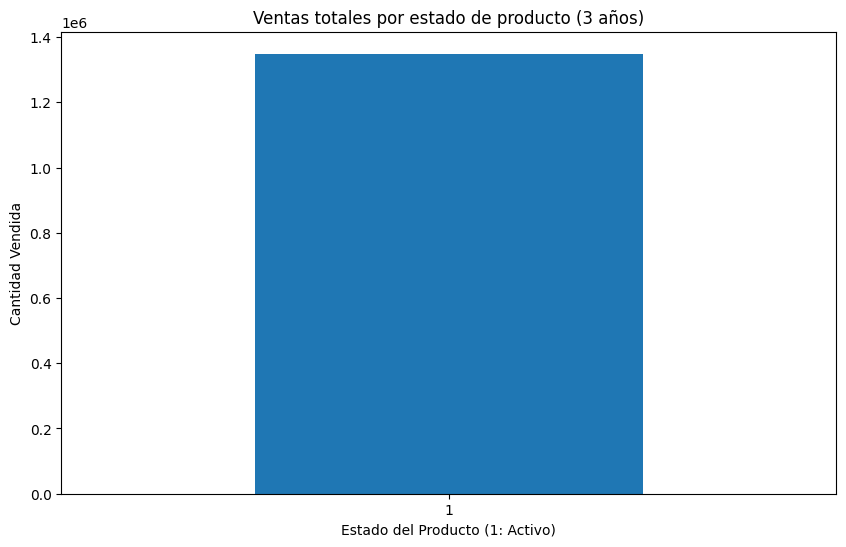

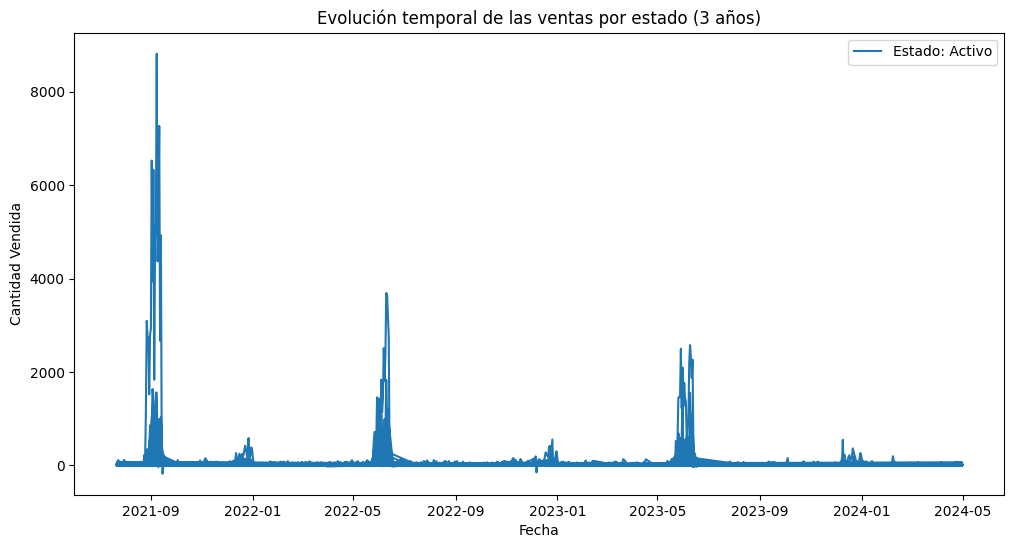

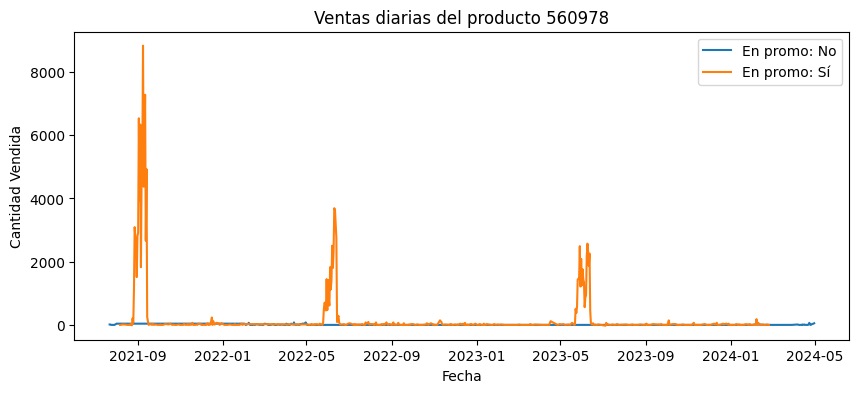

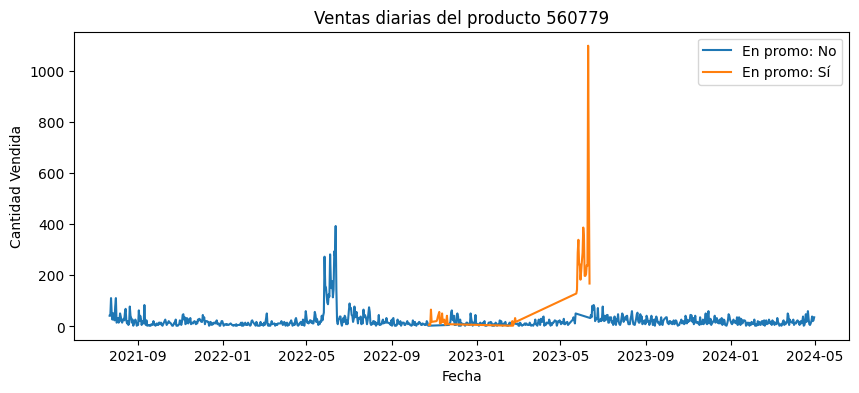

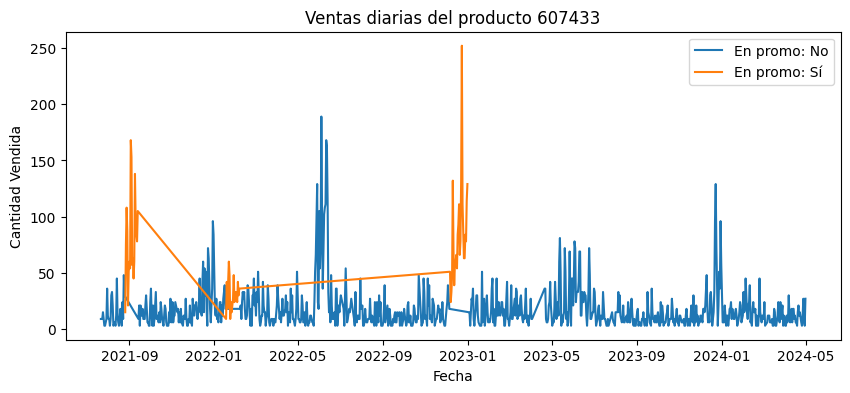

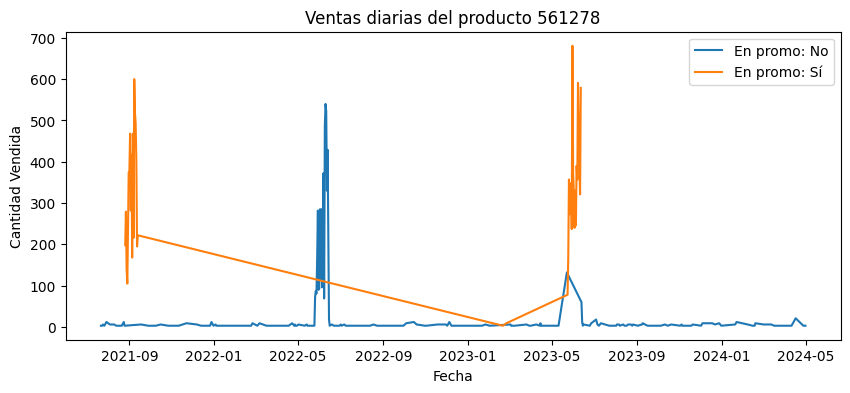

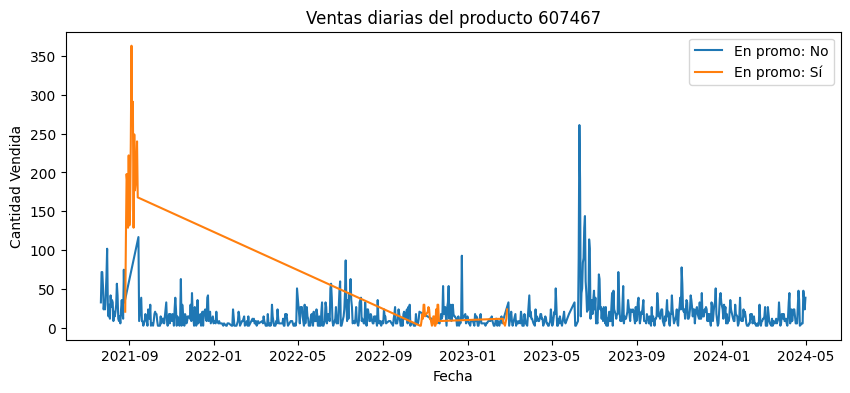

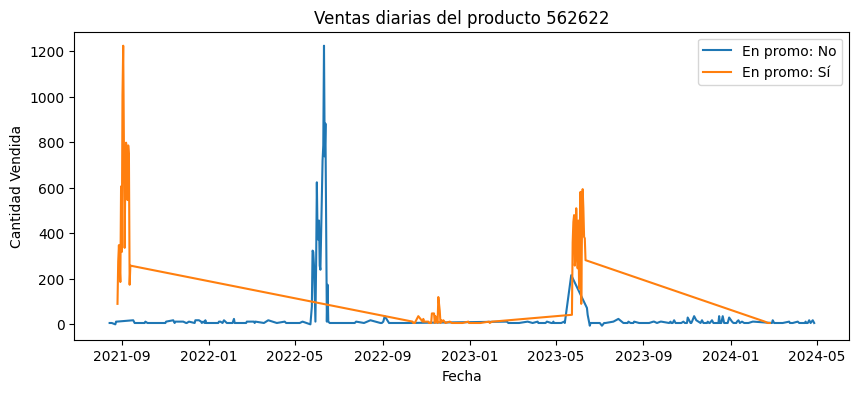

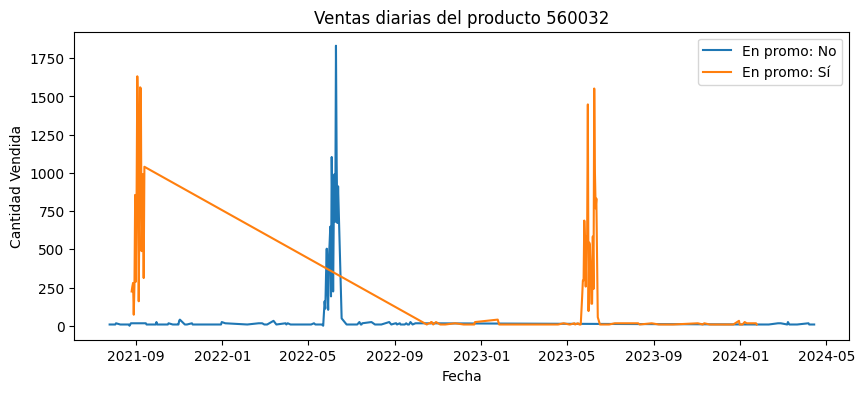

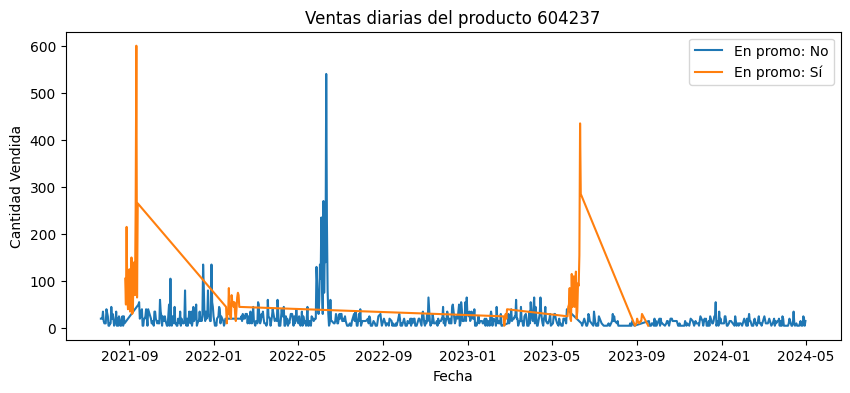

In [31]:
# Ventas totales por estado de producto (agregado en el tiempo):
ventas_por_estado = ventas_diarias.groupby('status_hoy')['cantidad_vendida'].sum()

plt.figure(figsize=(10, 6))
ventas_por_estado.plot(kind='bar', rot=0)
plt.title('Ventas totales por estado de producto (3 años)')
plt.xlabel('Estado del Producto (1: Activo)')
plt.ylabel('Cantidad Vendida')
plt.show()

# Evolución temporal de las ventas por estado (agregado por producto):
plt.figure(figsize=(12, 6))
for estado in ventas_diarias['status_hoy'].unique():
    ventas_estado = ventas_diarias[ventas_diarias['status_hoy'] == estado]
    if not ventas_estado.empty:
        plt.plot(ventas_estado['MOVFEC'], ventas_estado['cantidad_vendida'], label=f'Estado: Activo' if estado == 1 else f'Estado {estado}')

plt.title('Evolución temporal de las ventas por estado (3 años)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.show()

# Ventas diarias de los 10 productos más vendidos:
for producto in top_10_productos['PRDCODEXT']:
    ventas_producto = ventas_diarias_top_10[ventas_diarias_top_10['PRDCODEXT'] == producto]
    if not ventas_producto.empty:
        plt.figure(figsize=(10, 4))
        for promocion in ventas_producto['En Promoción'].unique():
            ventas_promocion = ventas_producto[ventas_producto['En Promoción'] == promocion]
            label = f'En promo: Sí' if promocion == 'En promo' else f'En promo: No'
            plt.plot(ventas_promocion['MOVFEC'], ventas_promocion['cantidad_vendida'], label=label)

        plt.title(f'Ventas diarias del producto {producto}')
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad Vendida')
        plt.legend()
        plt.show()

In [32]:
# Unir datos de ventas con productos
ventas_productos = pd.merge(ventas, productos, how='left', left_on='PRDCODEXT', right_on='Cod')

# Crear columnas indicadoras para 'Cat_216' y 'Cat_217'
ventas_productos['Cat_216'] = ventas_productos['Cat'].apply(lambda x: 1 if x == 216 else 0)
ventas_productos['Cat_217'] = ventas_productos['Cat'].apply(lambda x: 1 if x == 217 else 0)

print("Columnas de 'ventas_productos':", ventas_productos.columns)

Columnas de 'ventas_productos': Index(['LOCCOD', 'MOVFEC', 'PRDCODEXT', 'ACPRCANTVEND', 'ACPRIMPVEN', 'Cod',
       'Status Hoy', 'Prov', 'Cat', 'Tipo Prov', 'Cat_216', 'Cat_217'],
      dtype='object')


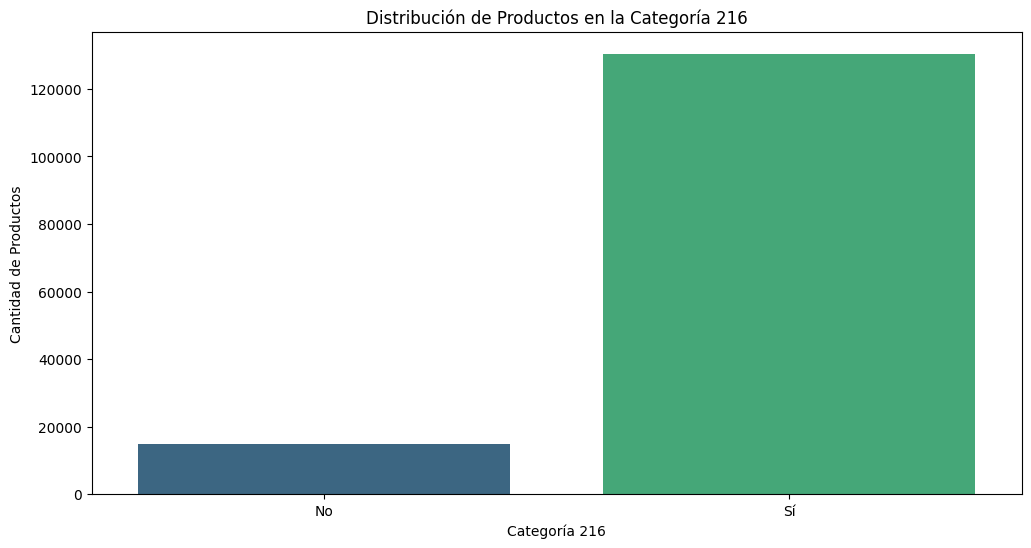

In [33]:
# Contar productos en la categoría 216
cantidad_cat_216 = ventas_productos['Cat_216'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=cantidad_cat_216.index, y=cantidad_cat_216.values, palette='viridis', hue=cantidad_cat_216.index)
plt.title('Distribución de Productos en la Categoría 216')
plt.xlabel('Categoría 216')
plt.ylabel('Cantidad de Productos')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.legend().set_visible(False)  # Oculta la leyenda
plt.show()


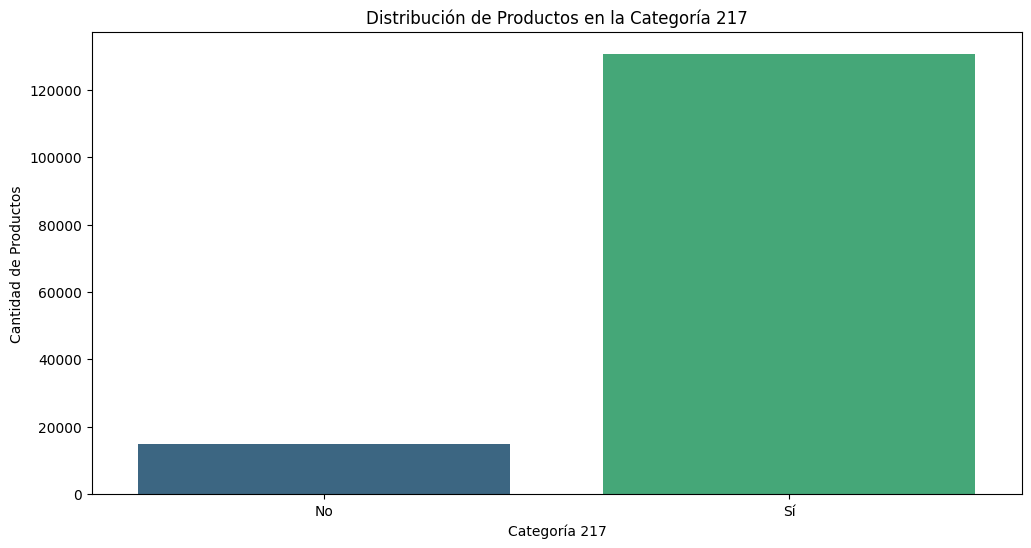

In [34]:
# Contar productos en la categoría 217
cantidad_cat_217 = ventas_productos['Cat_217'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=cantidad_cat_216.index, y=cantidad_cat_217.values, palette='viridis', hue=cantidad_cat_216.index)
plt.title('Distribución de Productos en la Categoría 217')
plt.xlabel('Categoría 217')
plt.ylabel('Cantidad de Productos')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.legend().set_visible(False)
plt.show()

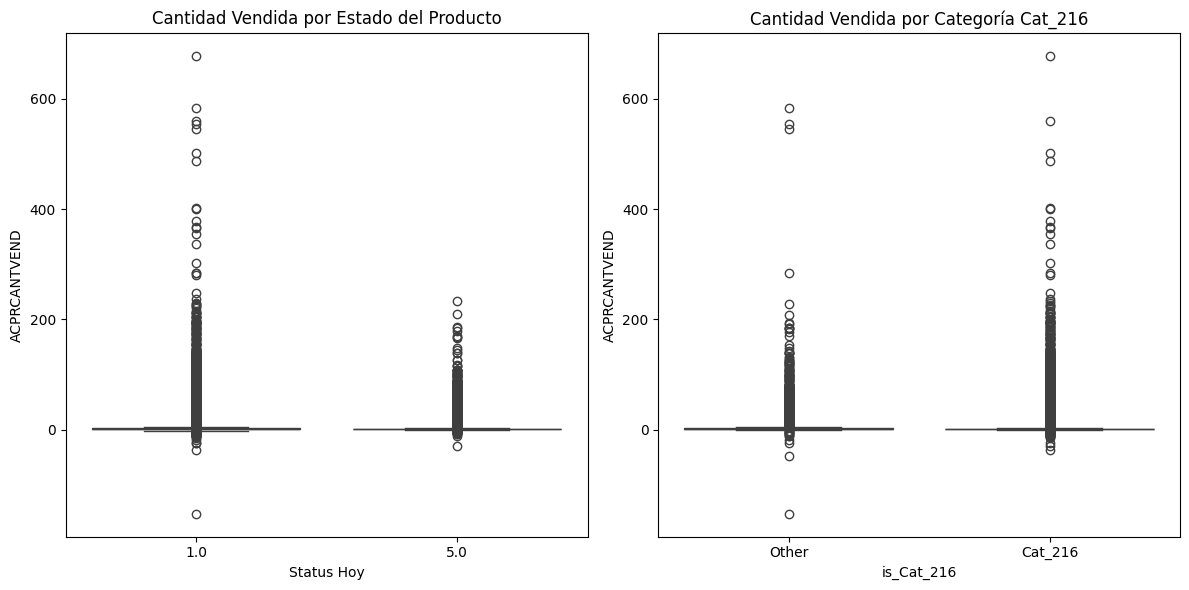

In [35]:
# Asegura que la columna se creó correctamente
ventas_productos['is_Cat_216'] = ventas_productos['Cat'].apply(lambda x: 1 if x == 216 else 0)

# Gráfico
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Status Hoy', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Estado del Producto')

plt.subplot(1, 2, 2)
sns.boxplot(x='is_Cat_216', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Categoría Cat_216')
plt.xticks([0, 1], ['Other', 'Cat_216'])

plt.tight_layout()
plt.show()

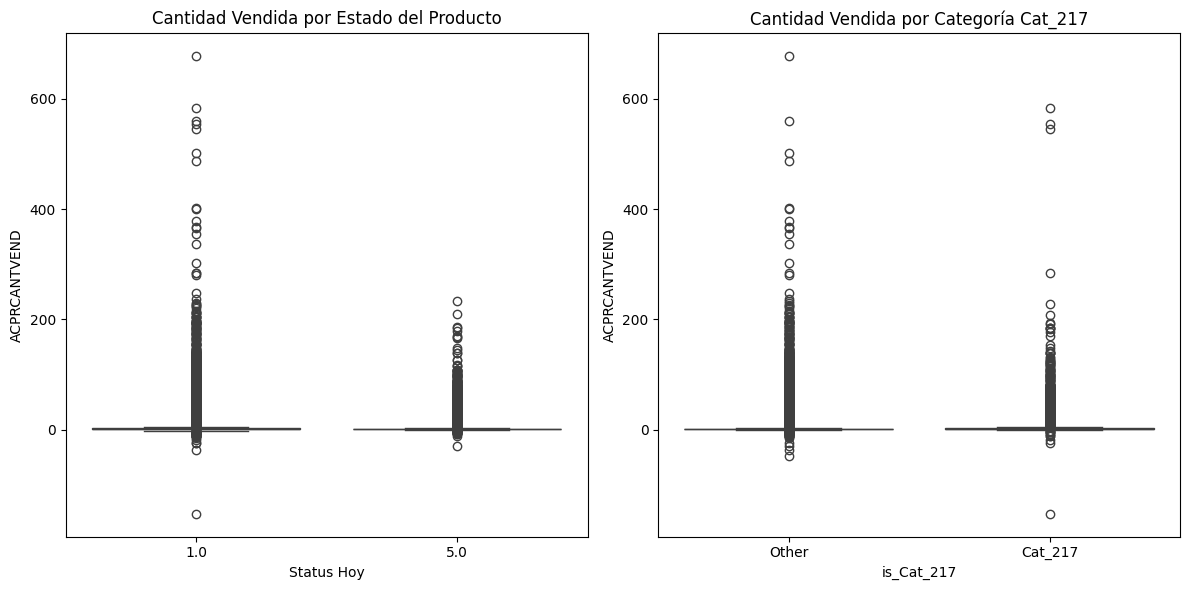

In [36]:
ventas_productos['is_Cat_217'] = ventas_productos['Cat'].apply(lambda x: 1 if x == 217 else 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Status Hoy', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Estado del Producto')

plt.subplot(1, 2, 2)
sns.boxplot(x='is_Cat_217', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Categoría Cat_217')
plt.xticks([0, 1], ['Other', 'Cat_217'])

plt.tight_layout()
plt.show()


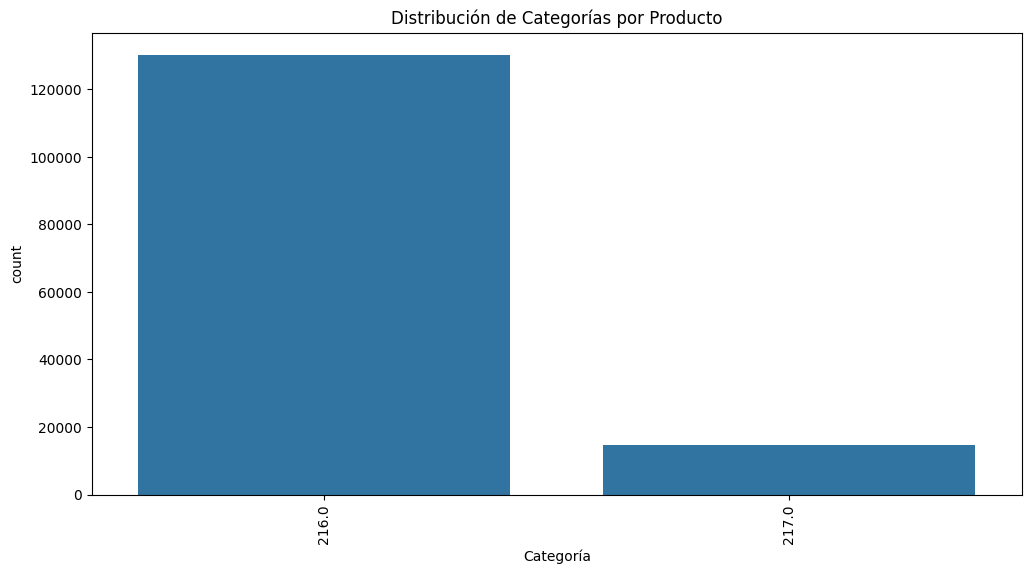

In [37]:
# Distribución de categorías
plt.figure(figsize=(12, 6))
sns.countplot(x='Cat', data=ventas_productos)
plt.title('Distribución de Categorías por Producto')
plt.xlabel('Categoría')
plt.xticks(rotation=90)
plt.show()

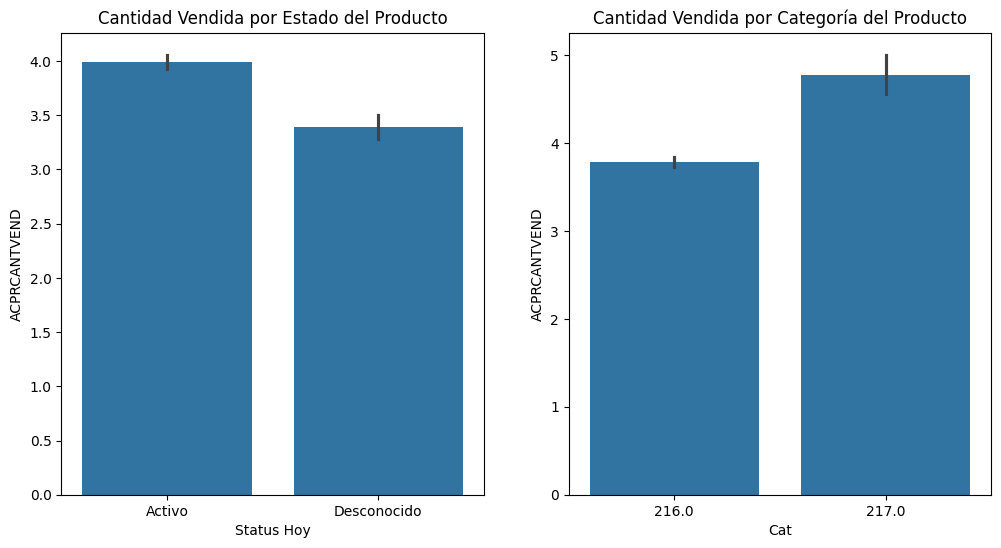

In [38]:
# Explorar las relaciones entre variables
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Status Hoy', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Estado del Producto')
plt.xticks([0, 1], ['Activo', 'Desconocido'])

plt.subplot(1, 2, 2)
sns.barplot(x='Cat', y='ACPRCANTVEND', data=ventas_productos)
plt.title('Cantidad Vendida por Categoría del Producto')
plt.show()

{'Activo': 119902, 'Desconocido': 25135, 'Congelado': 0, 'Congelado Compra': 0}


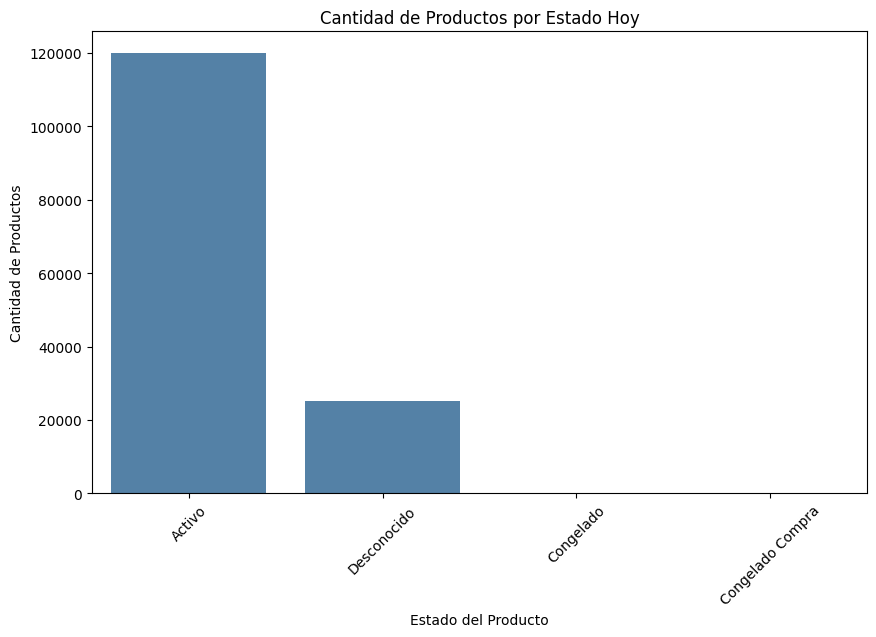

In [39]:
# Contar los valores 1 (activo), 2 (congelado), 3 (congelado compra) y 5 (desconocido).

# Contar los valores 1 (activo) y 5 (desconocido)
activo_count = (ventas_productos['Status Hoy'] == 1).sum()
desconocido_count = (ventas_productos['Status Hoy'] == 5).sum()

# Contar 2 (Congelado) y 3 (Congelado Compra) como 0 si no están presentes
congelado_count = (ventas_productos['Status Hoy'] == 2).sum()
congelado_compra_count = (ventas_productos['Status Hoy'] == 3).sum()

# Crear un diccionario de conteo
estado_counts = {
    'Activo': activo_count,
    'Desconocido': desconocido_count,
    'Congelado': congelado_count,
    'Congelado Compra': congelado_compra_count
}

# Imprimir los conteos para verificar
print(estado_counts)

# Crear un DataFrame a partir del conteo
estado_counts_df = pd.Series(estado_counts)

# Visualizar la cantidad de productos por estado
plt.figure(figsize=(10, 6))
sns.barplot(x=estado_counts_df.index, y=estado_counts_df.values, color='steelblue')
plt.title('Cantidad de Productos por Estado Hoy')
plt.xlabel('Estado del Producto')
plt.ylabel('Cantidad de Productos')
plt.xticks(rotation=45)
plt.show()


<Figure size 1600x800 with 0 Axes>

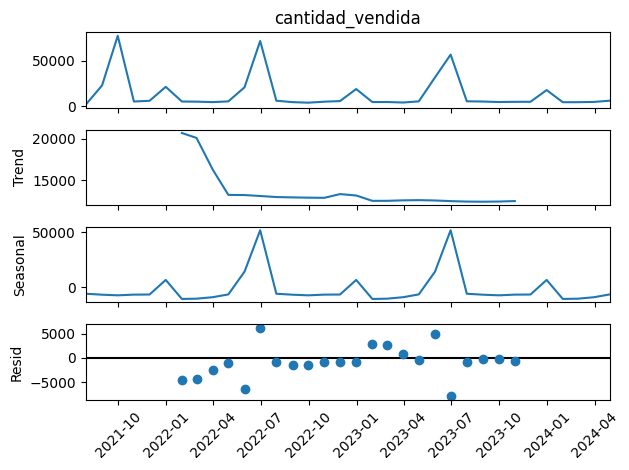

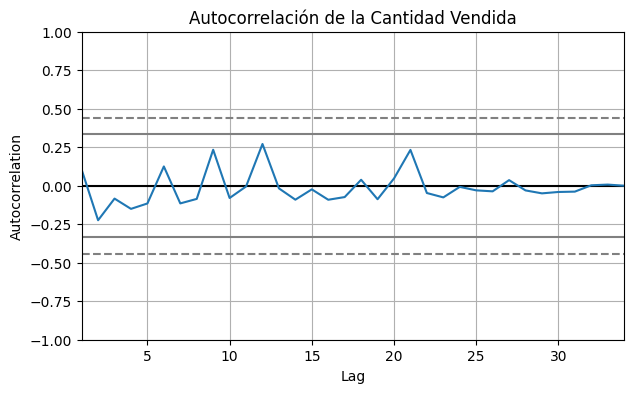

In [40]:
# Renombrar la columna para que sea 'cantidad_vendida'
ventas_mensuales.rename(columns={'ACPRCANTVEND': 'cantidad_vendida'}, inplace=True)

# Descomposición de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ajustar el tamaño de la figura
plt.figure(figsize=(16, 8))

# Realizar la descomposición
result = seasonal_decompose(ventas_mensuales['cantidad_vendida'], model='additive')
result.plot()

# Ajustar el formato de las fechas en la gráfica de descomposición
plt.xticks(rotation=45) 
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Ubica las fechas automáticamente
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de fecha (año-mes)

plt.tight_layout() 
plt.show()

# Autocorrelación
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(7, 4))
autocorrelation_plot(ventas_mensuales['cantidad_vendida'])
plt.title('Autocorrelación de la Cantidad Vendida')
plt.show()


In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import ipywidgets as widgets

# Descomposición de la serie temporal diaria para un producto único
productos_unicos = sorted(ventas['PRDCODEXT'].unique())

# Menú desplegable para seleccionar el producto
dropdown_producto = widgets.Dropdown(
options=productos_unicos,
description='Selecciona un producto:',
disabled=False,
)

# Función para actualizar los gráficos
def actualizar_graficos(producto):
    # Filtrar datos para el producto seleccionado
    ventas_producto = ventas[ventas['PRDCODEXT'] == producto].set_index('MOVFEC')

    plt.figure(figsize=(10, 4))

    if len(ventas_producto) >= 730:  # Al menos 2 años de datos diarios
        # Descomposición de la serie temporal
        result = seasonal_decompose(ventas_producto['ACPRCANTVEND'], model='additive', period=365)

        # Gráfico de descomposición
        result.plot()
        plt.title(f'Descomposición de la serie temporal para el producto {producto}')

        # Gráfico de autocorrelación
        plt.figure(figsize=(10, 4))
        autocorrelation_plot(ventas_producto['ACPRCANTVEND'])
        plt.title(f'Autocorrelación para el producto {producto}')
        plt.show()
    else:
        # Gráfico de barras simple si no hay suficientes datos para la descomposición
        plt.bar(ventas_producto.index, ventas_producto['ACPRCANTVEND'])
        plt.title(f'Ventas diarias para el producto {producto} (No hay suficientes datos para la descomposición)')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas Diarias')
        plt.xticks(rotation=45)

    plt.show()

# Vincular el menú desplegable con la función de actualización
widgets.interact(actualizar_graficos, producto=dropdown_producto)

# 561898 se vendió mucho en setiembre de 2021

In [ ]:
# Asegura que la columna MOVFEC esté en formato de fecha
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'])

# Agregar una nueva columna para el año
ventas['Año'] = ventas['MOVFEC'].dt.year

# Agrupar las ventas por año y producto, sumando la cantidad vendida
ventas_anuales = ventas.groupby(['PRDCODEXT', 'Año'], as_index=False)['ACPRCANTVEND'].sum()

# Obtener los códigos de producto únicos y ordenarlos para el menú desplegable
productos_unicos = sorted(ventas['PRDCODEXT'].unique())

# Crear un menú desplegable interactivo para seleccionar el producto
dropdown_producto = widgets.Dropdown(
    options=productos_unicos,
    description='Selecciona un producto:',
)

# Función para actualizar los gráficos según el producto seleccionado
def actualizar_graficos(producto):
    # Filtrar los datos de ventas anuales para el producto específico
    ventas_producto = ventas_anuales[ventas_anuales['PRDCODEXT'] == producto]

    plt.figure(figsize=(10, 4))  # Establecer el tamaño de la figura

    # Verificar si hay suficientes datos (al menos 2 años) para la descomposición
    if len(ventas_producto) >= 2:
        # Descomponer la serie temporal en componentes (tendencia, estacionalidad, residuo)
        result = seasonal_decompose(ventas_producto['ACPRCANTVEND'], model='additive', period=1)

        # Gráfico de descomposición
        result.plot()
        plt.title(f'Descomposición de ventas anuales para el producto {producto}')
        plt.show()

        # Gráfico de autocorrelación
        plt.figure(figsize=(10, 4))
        autocorrelation_plot(ventas_producto['ACPRCANTVEND'])
        plt.title(f'Autocorrelación para el producto {producto}')
        plt.show()
    else:
        # Si no hay suficientes datos para la descomposición, mostrar un gráfico de barras simple
        plt.bar(ventas_producto['Año'], ventas_producto['ACPRCANTVEND'])
        plt.title(f'Ventas anuales para el producto {producto} (Insuficientes datos para descomposición)')
        plt.xlabel('Año')
        plt.ylabel('Ventas Anuales')
        plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
        plt.show()

# Vincular el menú desplegable con la función de actualización de gráficos
widgets.interact(actualizar_graficos, producto=dropdown_producto)

interactive(children=(Dropdown(description='Selecciona un producto:', options=(306252, 540001, 540660, 542168,…

<function __main__.actualizar_graficos(producto)>

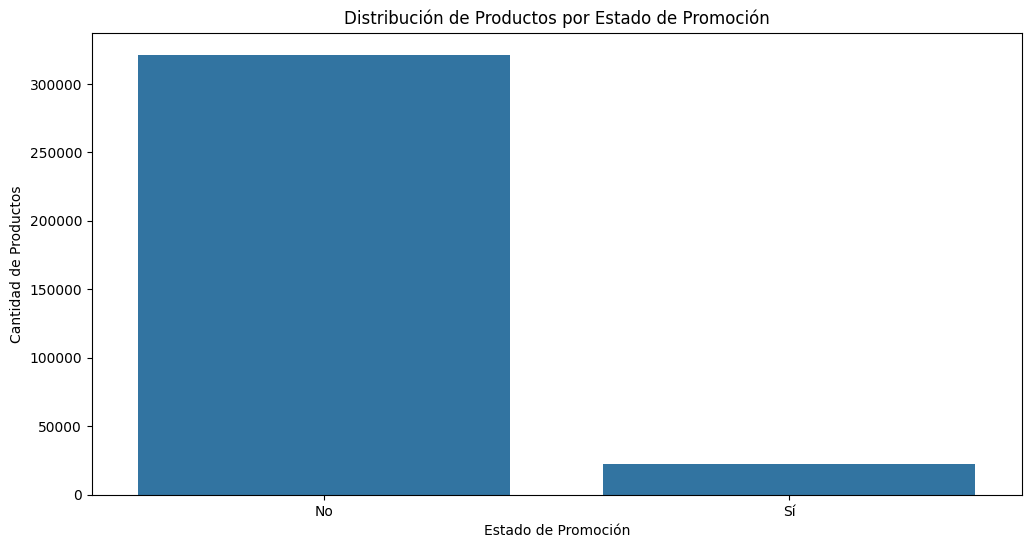

In [41]:
# Unir datos de ventas con productos y promociones
ventas_productos_promo = pd.merge(ventas_productos, promoción, how='left', on='PRDCODEXT')

# Columna que indica si el producto estaba en promoción en la fecha de venta #######
ventas_productos_promo['En Promoción'] = (
    (ventas_productos_promo['MOVFEC'] >= ventas_productos_promo['PROMDEFFECDES']) &
    (ventas_productos_promo['MOVFEC'] <= ventas_productos_promo['PROMDEFFECHAS'])
)

# Reemplazar True/False por "Sí"/"No"
ventas_productos_promo['En Promoción'] = ventas_productos_promo['En Promoción'].replace({True: 'Sí', False: 'No'})

# Visualización de la distribución de productos por estado de promoción
plt.figure(figsize=(12, 6))
sns.countplot(x='En Promoción', data=ventas_productos_promo)
plt.title('Distribución de Productos por Estado de Promoción')
plt.xlabel('Estado de Promoción')
plt.ylabel('Cantidad de Productos')
plt.show()

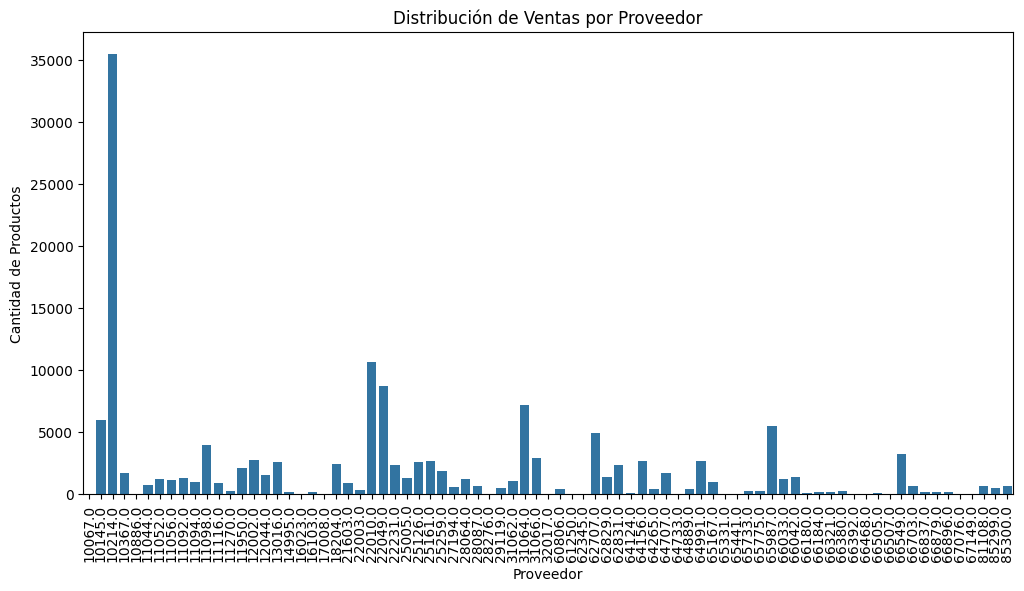

In [42]:
# Ventas por proveedor
plt.figure(figsize=(12, 6))
sns.countplot(x='Prov', data=ventas_productos)
plt.title('Distribución de Ventas por Proveedor')
plt.xlabel('Proveedor')
plt.ylabel('Cantidad de Productos')
plt.xticks(rotation=90)
plt.show()

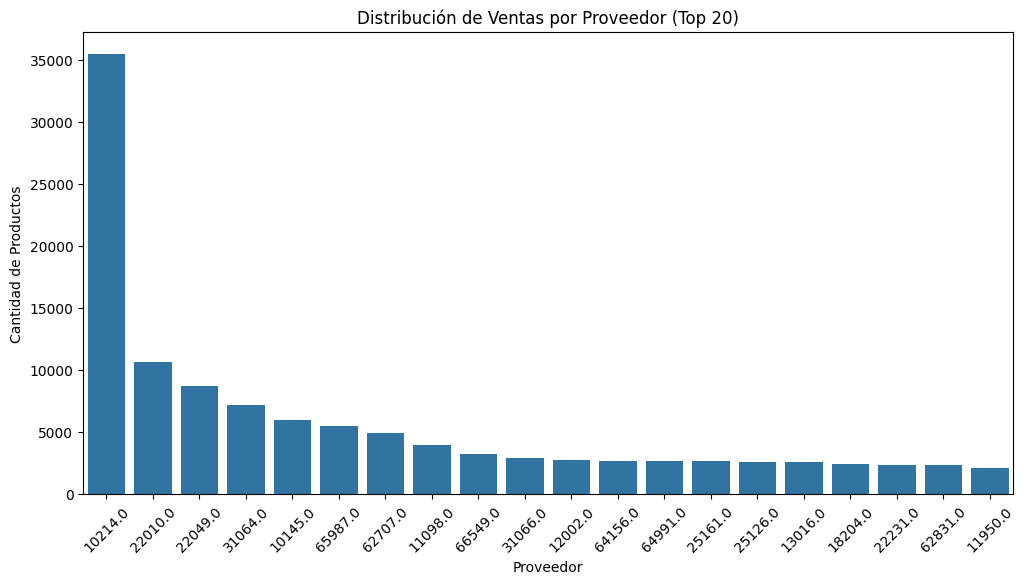

In [43]:
# Seleccionar los 20 principales proveedores
top_proveedores = ventas_productos['Prov'].value_counts().head(20).index

# Filtrar los datos
ventas_top_proveedores = ventas_productos[ventas_productos['Prov'].isin(top_proveedores)]

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.countplot(x='Prov', data=ventas_top_proveedores, order=top_proveedores)
plt.title('Distribución de Ventas por Proveedor (Top 20)')
plt.xlabel('Proveedor')
plt.ylabel('Cantidad de Productos')
plt.xticks(rotation=45)
plt.show()

In [44]:
ventas['ACPRIMPVEN'] = ventas['ACPRIMPVEN'].astype(float)

# Calcular la duración de cada promoción en días
promoción['DURACION'] = (promoción['PROMDEFFECHAS'] - promoción['PROMDEFFECDES']).dt.days

# Unir las ventas con las promociones
ventas_promoción = pd.merge(ventas, promoción, on='PRDCODEXT', how='left')

# Filtrar ventas que ocurrieron durante promociones
ventas_promoción = ventas_promoción[(ventas_promoción['MOVFEC'] >= ventas_promoción['PROMDEFFECDES']) &
                                    (ventas_promoción['MOVFEC'] <= ventas_promoción['PROMDEFFECHAS'])]

(ventas_promoción)

,LOCCOD,MOVFEC,PRDCODEXT,ACPRCANTVEND,ACPRIMPVEN,PROMDEFFECDES,PROMDEFFECHAS,DURACION
5334,5201,2021-05-17,560908,3,927.0,2021-05-17,2021-05-30,13.0
5338,5201,2021-05-17,560959,1,309.0,2021-05-17,2021-05-30,13.0
5586,5201,2021-05-18,562218,1,219.0,2021-05-17,2021-05-30,13.0
5592,5201,2021-05-18,562219,1,219.0,2021-05-17,2021-05-30,13.0
5662,5201,2021-05-18,560959,3,927.0,2021-05-17,2021-05-30,13.0
...,...,...,...,...,...,...,...,...
343227,5201,2024-04-28,560854,4,756.0,2024-04-08,2024-04-28,20.0
343243,5201,2024-04-28,561044,1,249.0,2024-04-08,2024-04-28,20.0
343246,5201,2024-04-28,561049,1,249.0,2024-04-08,2024-04-28,20.0
343311,5201,2024-04-28,561060,1,249.0,2024-04-08,2024-04-28,20.0


In [45]:
# Crear la columna 'facturación' basada en 'ACPRIMPVEN'
ventas_promoción['facturación'] = ventas_promoción['ACPRIMPVEN']

# Asegurarse de que 'facturación' esté en float
ventas_promoción['facturación'] = ventas_promoción['facturación'].astype(float)

# Calcular la facturación total para cada periodo de promoción
promoción_facturación = ventas_promoción.groupby(['PRDCODEXT', 'PROMDEFFECDES', 'PROMDEFFECHAS']).agg({'facturación': 'sum'}).reset_index()

# Calcular la duración de cada promoción en días
promoción_facturación['DURACION'] = (promoción_facturación['PROMDEFFECHAS'] - promoción_facturación['PROMDEFFECDES']).dt.days

# Ordenar por mayor facturación
promoción_facturación = promoción_facturación.sort_values(by='facturación', ascending=False)

# Verificar el DataFrame final
(promoción_facturación.head())

,PRDCODEXT,PROMDEFFECDES,PROMDEFFECHAS,facturación,DURACION
409,561278,2023-05-24,2023-06-12,49588322.0,19
311,560978,2023-05-03,2023-08-02,48210787.0,91
312,560978,2023-05-24,2023-06-12,48142418.0,19
407,561278,2021-08-26,2021-09-13,25225396.0,18
306,560978,2022-05-03,2022-08-01,21728364.0,90


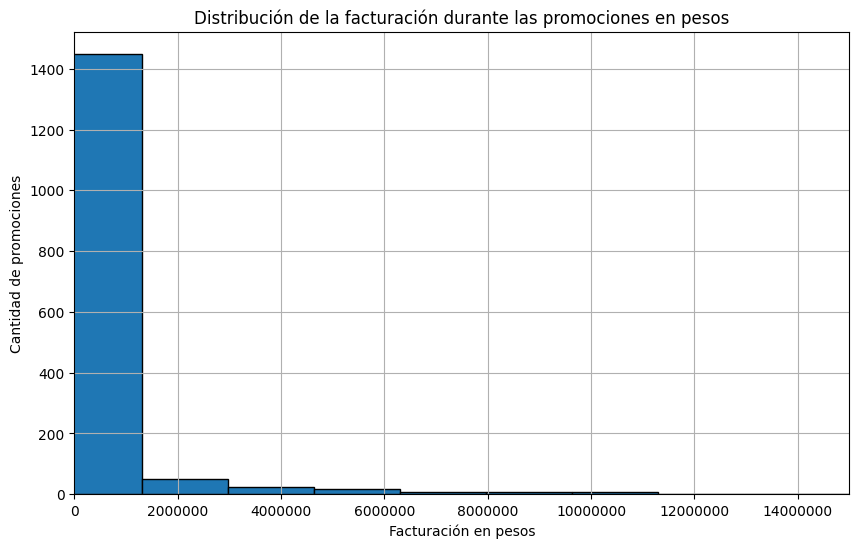

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(promoción_facturación['facturación'], bins=30, edgecolor='black')
plt.title('Distribución de la facturación durante las promociones en pesos')
plt.xlabel('Facturación en pesos')
plt.ylabel('Cantidad de promociones')
plt.grid(True)

# Ajustar límites del eje x
plt.xlim(0, 15000000)

# Formatear los ticks del eje x para evitar notación científica
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}'))

plt.show()

In [47]:
# Crear características basadas en ventas anteriores (lags) y medias móviles.

ventas = ventas.sort_values('MOVFEC')
ventas['lag_1'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].shift(1)
ventas['lag_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].shift(7)
ventas['rolling_mean_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=7).mean())
ventas['rolling_std_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=7).std())

(ventas)

,LOCCOD,MOVFEC,PRDCODEXT,ACPRCANTVEND,ACPRIMPVEN,lag_1,lag_7,rolling_mean_7,rolling_std_7
0,5201,2021-05-02,600790,7,1393.0,NaN,NaN,NaN,NaN
113,5201,2021-05-02,561848,4,992.0,NaN,NaN,NaN,NaN
114,5201,2021-05-02,561854,2,910.0,NaN,NaN,NaN,NaN
115,5201,2021-05-02,561857,1,105.0,NaN,NaN,NaN,NaN
116,5201,2021-05-02,561861,2,466.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
145168,5201,2024-04-30,561914,1,495.0,1.0,2.0,1.285714,0.755929
145169,5201,2024-04-30,561933,2,760.0,1.0,1.0,1.142857,0.377964
145170,5201,2024-04-30,561961,1,679.0,1.0,1.0,1.142857,0.377964
145152,5201,2024-04-30,561280,1,805.0,2.0,1.0,1.285714,0.487950


In [48]:
# Convertir fechas de promoción a formato datetime
promoción['PROMDEFFECDES'] = pd.to_datetime(promoción['PROMDEFFECDES'])
promoción['PROMDEFFECHAS'] = pd.to_datetime(promoción['PROMDEFFECHAS'])

In [49]:
# Unir datos de ventas con promociones para crear el indicador
ventas_promo = pd.merge(ventas, promoción, how='left', left_on='PRDCODEXT', right_on='PRDCODEXT')

In [50]:
# Identificar columnas numéricas
numeric_columns = ventas_promo.select_dtypes(include=['number']).columns

# Imputar valores faltantes con la media solo en las columnas numéricas
ventas_promo[numeric_columns] = ventas_promo[numeric_columns].fillna(ventas_promo[numeric_columns].mean())

# Imprimir las primeras filas para verificar
print(ventas_promo.head().to_markdown(index=False, numalign="left", stralign="left"))

| LOCCOD   | MOVFEC              | PRDCODEXT   | ACPRCANTVEND   | ACPRIMPVEN   | lag_1   | lag_7   | rolling_mean_7   | rolling_std_7   | PROMDEFFECDES       | PROMDEFFECHAS       | DURACION   |
|:---------|:--------------------|:------------|:---------------|:-------------|:--------|:--------|:-----------------|:----------------|:--------------------|:--------------------|:-----------|
| 5201     | 2021-05-02 00:00:00 | 600790      | 7              | 1393         | 4.60403 | 4.72404 | 4.6937           | 3.2669          | 2022-06-15 00:00:00 | 2022-07-03 00:00:00 | 18         |
| 5201     | 2021-05-02 00:00:00 | 600790      | 7              | 1393         | 4.60403 | 4.72404 | 4.6937           | 3.2669          | 2023-05-04 00:00:00 | 2023-08-06 00:00:00 | 94         |
| 5201     | 2021-05-02 00:00:00 | 600790      | 7              | 1393         | 4.60403 | 4.72404 | 4.6937           | 3.2669          | 2024-01-03 00:00:00 | 2024-01-21 00:00:00 | 18         |
| 5201     | 2021-05-02 0

In [51]:
# Crear indicador de promoción
ventas_promo['is_promo'] = ((ventas_promo['MOVFEC'] >= ventas_promo['PROMDEFFECDES']) &
                            (ventas_promo['MOVFEC'] <= ventas_promo['PROMDEFFECHAS'])).astype(int)

(ventas_promo)

,LOCCOD,MOVFEC,PRDCODEXT,ACPRCANTVEND,ACPRIMPVEN,lag_1,lag_7,rolling_mean_7,rolling_std_7,PROMDEFFECDES,PROMDEFFECHAS,DURACION,is_promo
0,5201,2021-05-02,600790,7,1393.0,4.604031,4.72404,4.693701,3.266899,2022-06-15,2022-07-03,18.0,0
1,5201,2021-05-02,600790,7,1393.0,4.604031,4.72404,4.693701,3.266899,2023-05-04,2023-08-06,94.0,0
2,5201,2021-05-02,600790,7,1393.0,4.604031,4.72404,4.693701,3.266899,2024-01-03,2024-01-21,18.0,0
3,5201,2021-05-02,561848,4,992.0,4.604031,4.72404,4.693701,3.266899,2021-08-26,2021-09-13,18.0,0
4,5201,2021-05-02,561848,4,992.0,4.604031,4.72404,4.693701,3.266899,2022-10-10,2023-01-29,111.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344117,5201,2024-04-30,561961,1,679.0,1.000000,1.00000,1.142857,0.377964,2023-05-04,2023-08-06,94.0,0
344118,5201,2024-04-30,561961,1,679.0,1.000000,1.00000,1.142857,0.377964,2023-02-01,2023-05-02,90.0,0
344119,5201,2024-04-30,561961,1,679.0,1.000000,1.00000,1.142857,0.377964,2023-05-03,2023-08-02,91.0,0
344120,5201,2024-04-30,561280,1,805.0,2.000000,1.00000,1.285714,0.487950,2023-02-20,2023-02-26,6.0,0


In [52]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']
scaler = StandardScaler()
ventas_promo[features_to_scale] = scaler.fit_transform(ventas_promo[features_to_scale])

In [53]:
# Crear características adicionales
ventas_promo['dia_semana'] = ventas_promo['MOVFEC'].dt.dayofweek
ventas_promo['mes'] = ventas_promo['MOVFEC'].dt.month
ventas_promo['año'] = ventas_promo['MOVFEC'].dt.year
ventas_promo['día_del_mes'] = ventas_promo['MOVFEC'].dt.day

# Selección de características
features = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'is_promo', 'dia_semana', 'mes', 'año', 'día_del_mes']
ventas_promo = ventas_promo.dropna(subset=features)  # Asegurarse de que no haya valores faltantes en las características

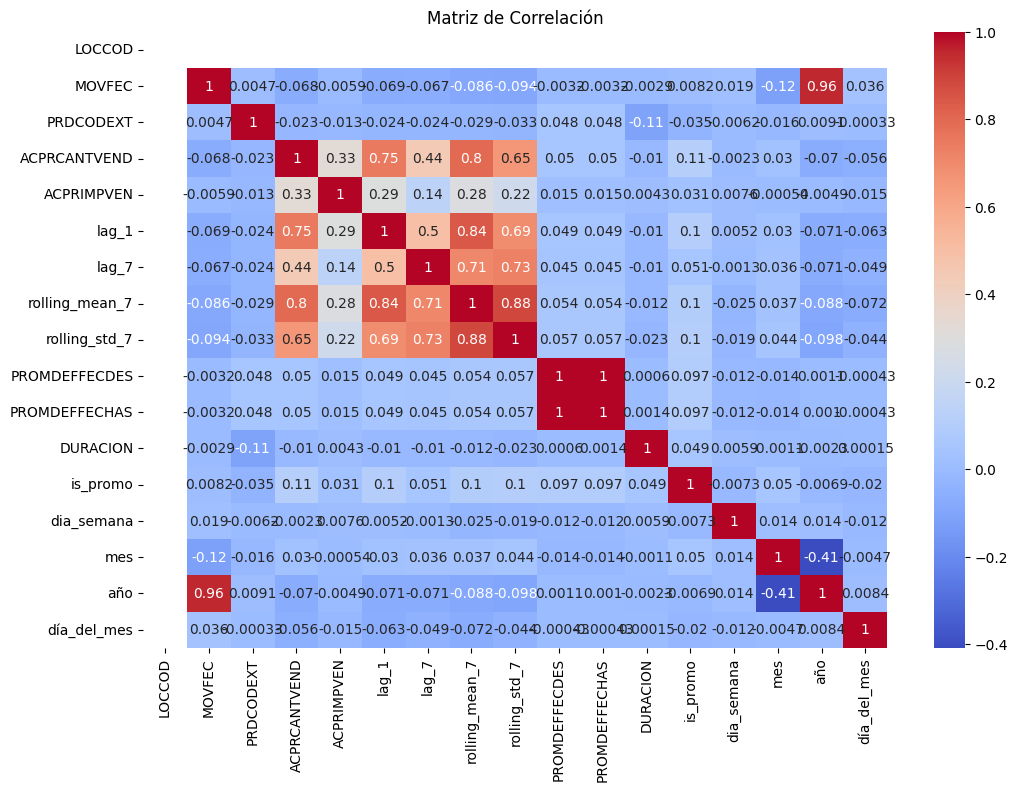

In [54]:
# Normalización/Estandarización
from sklearn.preprocessing import StandardScaler

# Función para limpiar y convertir a numérico
def clean_and_convert_to_numeric(df, column):
    df[column] = df[column].astype(str).str.replace(r'[$,]', '', regex=True)
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Limpiar y convertir las columnas que deberían ser numéricas
for column in ventas_promo.columns:
    if ventas_promo[column].dtype == 'object':
        clean_and_convert_to_numeric(ventas_promo, column)

# Normalización/Estandarización
features_to_scale = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']
scaler = StandardScaler()
ventas_promo[features_to_scale] = scaler.fit_transform(ventas_promo[features_to_scale])

# Verificación de correlación
corr_matrix = ventas_promo.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [55]:
# Análisis de Promociones

# Filtrar ventas durante el período de promoción
ventas_durante_promocion = ventas_promo[ventas_promo['is_promo'] == 1]

# Filtrar ventas fuera del período de promoción
ventas_fuera_promocion = ventas_promo[ventas_promo['is_promo'] == 0]

# Calcular ventas promedio durante promociones por producto
ventas_promedio_durante_promocion = ventas_durante_promocion.groupby('PRDCODEXT')['ACPRCANTVEND'].mean().reset_index()
ventas_promedio_durante_promocion.columns = ['PRDCODEXT', 'ventas_promedio_durante_promocion']

# Calcular ventas promedio fuera de promociones por producto
ventas_promedio_fuera_promocion = ventas_fuera_promocion.groupby('PRDCODEXT')['ACPRCANTVEND'].mean().reset_index()
ventas_promedio_fuera_promocion.columns = ['PRDCODEXT', 'ventas_promedio_fuera_promocion']

# Unir los dos dataframes para comparar
ventas_comparacion = pd.merge(ventas_promedio_durante_promocion, ventas_promedio_fuera_promocion, on='PRDCODEXT', how='inner')

# Calcular el incremento porcentual en ventas debido a promociones
ventas_comparacion['incremento_promocion'] = ((ventas_comparacion['ventas_promedio_durante_promocion'] - ventas_comparacion['ventas_promedio_fuera_promocion']) / ventas_comparacion['ventas_promedio_fuera_promocion']) * 100

# Ordenar por el incremento para identificar las mejores promociones
ventas_comparacion = ventas_comparacion.sort_values(by='incremento_promocion', ascending=False)

(ventas_comparacion.head(10))

,PRDCODEXT,ventas_promedio_durante_promocion,ventas_promedio_fuera_promocion,incremento_promocion
627,600030,3.500000,0.000000,inf
572,562811,38.000000,1.245455,2951.094891
593,562918,7.600000,0.250000,2940.000000
467,562594,51.157895,1.850962,2663.855092
596,562924,36.062500,1.411765,2454.427083
526,562710,44.578947,1.777778,2407.565789
294,561996,45.315789,1.823529,2385.059423
495,562639,78.789474,3.234043,2336.253463
132,561033,68.050000,2.925072,2226.438424
233,561769,45.450000,1.959732,2219.195205


In [56]:
# Conversión de fechas y manejo de valores faltantes
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], dayfirst=True, errors='coerce')
ventas['ACPRIMPVEN'] = pd.to_numeric(ventas['ACPRIMPVEN'].astype(str).str.replace(',', ''), errors='coerce')
ventas = ventas.dropna(subset=['MOVFEC', 'ACPRIMPVEN']).fillna(0)

In [57]:
# Crear la columna de ventas acumuladas a 15 días
ventas['ventas_15_dias'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=15).sum())

# Crear la columna de promedio de ventas a 15 días
ventas['promedio_15_dias'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=15).mean())

# Eliminar filas con valores NaN resultantes del cálculo de rolling sum y mean
ventas = ventas.dropna(subset=['ventas_15_dias', 'promedio_15_dias'])

In [58]:
ventas = ventas.drop_duplicates(subset=['LOCCOD', 'MOVFEC', 'PRDCODEXT'])

# Guardar el DataFrame limpio con los datos de 15 días
ventas.to_csv('VentasPR_limpio_15_dias.csv', index=False)

# Leer archivo para asegurar que es el correcto
ventas = pd.read_csv('VentasPR_limpio_15_dias.csv')

In [59]:
# Convertir las fechas de interés a tipo datetime
dias_festivos = pd.to_datetime(['2021-12-24', '2021-12-25', '2021-12-26',
                                '2022-12-24', '2022-12-25', '2022-12-26',
                                '2023-12-24', '2023-12-25', '2023-12-26',
                                '2024-01-01', '2024-12-25', '2024-07-04'])

# Convertir la columna 'MOVFEC' a tipo datetime si no lo está
ventas_promo['MOVFEC'] = pd.to_datetime(ventas_promo['MOVFEC'])

# Crear la columna 'es_festivo' basada en la condición de si la fecha está en dias_festivos
ventas_promo['es_festivo'] = ventas_promo['MOVFEC'].dt.date.isin(dias_festivos.date).astype(int)

# Calcular ventas totales en días festivos
ventas_festivos_total = ventas_promo[ventas_promo['es_festivo'] == 1]['PRDCODEXT'].count()

# Calcular ventas totales en días festivos con promoción
ventas_festivos_promo = ventas_promo[(ventas_promo['es_festivo'] == 1) & (ventas_promo['is_promo'] == 1)]['PRDCODEXT'].count()

# Calcular ventas totales en días festivos sin promoción
ventas_festivos_no_promo = ventas_festivos_total - ventas_festivos_promo

print(f"Ventas totales en días festivos: {ventas_festivos_total}")
print(f"Ventas totales en días festivos con promoción: {ventas_festivos_promo}")
print(f"Ventas totales en días festivos sin promoción: {ventas_festivos_no_promo}")


Ventas totales en días festivos: 2770
Ventas totales en días festivos con promoción: 165
Ventas totales en días festivos sin promoción: 2605


In [60]:
# Convertir las fechas en el dataframe promoción a tipo datetime
promoción['PROMDEFFECDES'] = pd.to_datetime(promoción['PROMDEFFECDES'], errors='coerce')

# Unir datos de ventas con promociones para crear el indicador
ventas_promo = pd.merge(ventas, promoción, how='left', on='PRDCODEXT')

# Imputar valores faltantes utilizando la mediana de las fechas presentes en PROMDEFFECDES
median_date = ventas_promo['PROMDEFFECDES'].median()
ventas_promo['PROMDEFFECDES'] = ventas_promo['PROMDEFFECDES'].fillna(median_date)

# Crear indicador de promoción
ventas_promo['is_promo'] = ((ventas_promo['MOVFEC'] >= ventas_promo['PROMDEFFECDES']) & (ventas_promo['MOVFEC'] <= ventas_promo['PROMDEFFECHAS'])).astype(int)

# Crear indicador de días festivos
dias_festivos = ['2024-01-01', '2024-12-25', '2024-07-04']  # Ejemplo
ventas_promo['es_festivo'] = ventas_promo['MOVFEC'].isin(pd.to_datetime(dias_festivos)).astype(int)

# Crear columna 'en_promo' para indicar si el producto está en promoción
ventas_promo['en_promo'] = ventas_promo['is_promo'] == 1

# Agrupar por producto y calcular las ventas cuando está en promoción y cuando no está
ventas_productos = ventas_promo.groupby(['PRDCODEXT', 'en_promo'])['ACPRCANTVEND'].sum().unstack(fill_value=0)

# Renombrar las columnas para mayor claridad
ventas_productos.columns = ['No', 'En_promo']
ventas_productos.reset_index(inplace=True)

(ventas_productos[['PRDCODEXT', 'En_promo', 'No']])

,PRDCODEXT,En_promo,No
0,306252,0,436
1,540001,0,755
2,540660,0,1320
3,542168,0,72
4,542169,0,144
...,...,...,...
1148,660993,82,39
1149,660994,0,157
1150,660995,212,592
1151,660996,0,67


In [61]:
pip install pycaret

Note: you may need to restart the kernel to use updated packages.


In [62]:
from pycaret.regression import *
from pycaret.datasets import get_data
from pycaret.internal.pipeline import Pipeline
from pandas.plotting import autocorrelation_plot
import joblib
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import os

In [63]:
# --- Fusionar el DataFrame de promoción con ventas basado en el código del producto ---
ventas = pd.merge(ventas, promoción[['PRDCODEXT', 'PROMDEFFECDES', 'PROMDEFFECHAS']], on='PRDCODEXT', how='left')

# --- Crear las características necesarias en el DataFrame fusionado ---
if 'PROMDEFFECDES' in ventas.columns and 'PROMDEFFECHAS' in ventas.columns:
    ventas['is_promo'] = ((ventas['MOVFEC'] >= ventas['PROMDEFFECDES']) &
                          (ventas['MOVFEC'] <= ventas['PROMDEFFECHAS'])).astype(int)
elif 'PROMDEFFECDES_x' in ventas.columns and 'PROMDEFFECHAS_x' in ventas.columns:
    ventas['is_promo'] = ((ventas['MOVFEC'] >= ventas['PROMDEFFECDES_x']) &
                          (ventas['MOVFEC'] <= ventas['PROMDEFFECHAS_x'])).astype(int)
else:
    print("Columnas de promoción no encontradas en el DataFrame de ventas.")

# Eliminar columnas duplicadas si existen
ventas.drop(columns=['PROMDEFFECDES', 'PROMDEFFECDES_x', 'PROMDEFFECDES_y',
                     'PROMDEFFECHAS', 'PROMDEFFECHAS_x', 'PROMDEFFECHAS_y'], errors='ignore', inplace=True)

# Convertir columna de fecha
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], errors='coerce')

# --- Crear características (lags, medias móviles, etc.) ---
ventas['lag_1'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].shift(1)
ventas['lag_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].shift(7)
ventas['rolling_mean_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=7).mean())
ventas['rolling_std_7'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(window=7).std())

# Rellenar NaNs en las nuevas características
ventas['lag_1'].fillna(0, inplace=True)
ventas['lag_7'].fillna(0, inplace=True)
ventas['rolling_mean_7'].fillna(ventas['ACPRCANTVEND'].mean(), inplace=True)
ventas['rolling_std_7'].fillna(ventas['ACPRCANTVEND'].std(), inplace=True)

# Acumulación de ventas a 15 días
ventas['ventas_15d'] = ventas.groupby('PRDCODEXT')['ACPRCANTVEND'].transform(lambda x: x.rolling(15, min_periods=1).sum())

# Componentes de fecha
ventas['dia_semana'] = ventas['MOVFEC'].dt.dayofweek
ventas['mes'] = ventas['MOVFEC'].dt.month
ventas['año'] = ventas['MOVFEC'].dt.year
ventas['día_del_mes'] = ventas['MOVFEC'].dt.day


In [64]:
# Definir el número de clusters
n_clusters = 5

# Clustering basado en ACPRCANTVEND e is_promo
clustering_features = ventas[['ACPRCANTVEND', 'is_promo']]
mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
ventas['cluster'] = mini_batch_kmeans.fit_predict(clustering_features)

# Clustering promocional basado en is_promo y ACPRCANTVEND
promo_clustering_features = ventas[['is_promo', 'ACPRCANTVEND']]
promo_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
ventas['promo_cluster'] = promo_kmeans.fit_predict(promo_clustering_features)

# Preparar los datos para el clustering de productos
productos_cluster_base = productos[['Cod', 'Cat']].rename(columns={'Cod': 'PRDCODEXT'})

# Realizar el clustering con diferente número de clusters y fusionar con ventas
for n_clusters in range(2, 6):  # Probar con 2, 3, 4, 5 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    productos_cluster = productos_cluster_base.copy()
    cluster_column = f'cluster_{n_clusters}'
    productos_cluster[cluster_column] = kmeans.fit_predict(productos_cluster[['Cat']])

    # Fusionar la información del cluster a ventas con sufijo único
    ventas = pd.merge(ventas, productos_cluster[['PRDCODEXT', cluster_column]], on='PRDCODEXT', how='left', suffixes=('', f'_{n_clusters}'))

    # Rellenar NaNs en el conjunto de ventas
    ventas.dropna(subset=['cluster', cluster_column], inplace=True)
    ventas['cluster'].fillna(-1, inplace=True)
    ventas[cluster_column].fillna(-1, inplace=True)

    # Dividir en conjunto de entrenamiento y prueba
    train, test = train_test_split(ventas, test_size=0.2, shuffle=False)

    # Rellenar NaNs en el conjunto de entrenamiento
    numeric_columns = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'is_promo', 'dia_semana', 'mes', 'año', 'día_del_mes']
    imputer = SimpleImputer(strategy='mean')
    train[numeric_columns] = imputer.fit_transform(train[numeric_columns])

In [67]:
    # --- Configuración de PyCaret ---

    exp_reg = setup(data=train,
                    target='ACPRCANTVEND',
                    session_id=123,
                    fold_strategy='timeseries',
                    fold=5,
                    numeric_features=numeric_columns + ['ventas_15d', 'cluster', cluster_column],
                    ignore_features=['LOCCOD', 'MOVFEC', 'PRDCODEXT', 'ACPRIMPVEN'],
                    remove_outliers=True,
                    outliers_threshold=0.05,
                    transformation=False,
                    transform_target=True,
                    data_split_shuffle=False,
                    fold_shuffle=False)

    # Comparar y crear el mejor modelo
    best_model = compare_models()
    model = create_model(best_model)
    tuned_model = tune_model(model)
    final_model = finalize_model(tuned_model)

    # Predecir en el conjunto de prueba
    predictions = predict_model(final_model, data=test)

    # Guardar el modelo entrenado
    joblib.dump(final_model, f'best_model_{n_clusters}_clusters.pkl')

,Description,Value
0,Session id,123
1,Target,ACPRCANTVEND
2,Target type,Regression
3,Original data shape,"(250836, 23)"
4,Transformed data shape,"(242056, 19)"
5,Transformed train set shape,"(166805, 19)"
6,Transformed test set shape,"(75251, 19)"
7,Ignore features,4
8,Numeric features,12
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6163,52.4797,6.2795,0.7317,0.1056,0.0535,11.8920
lightgbm,Light Gradient Boosting Machine,0.6814,58.0430,6.7349,0.7178,0.1089,0.0526,1.5940
rf,Random Forest Regressor,0.6144,60.5852,6.7916,0.6899,0.1062,0.0435,19.0360
gbr,Gradient Boosting Regressor,0.7642,65.2019,6.8925,0.6899,0.1195,0.0694,7.7680
xgboost,Extreme Gradient Boosting,0.6968,60.3330,6.8980,0.6823,0.1106,0.0558,1.5460
dt,Decision Tree Regressor,0.6793,63.1704,7.0209,0.6676,0.1340,0.0459,1.2680
ada,AdaBoost Regressor,1.8547,119.5390,9.6863,0.4399,0.2908,0.3169,3.1360
knn,K Neighbors Regressor,2.7299,157.3903,10.9971,0.2689,0.5051,1.0184,10.2060
dummy,Dummy Regressor,3.8777,201.6706,12.8989,-0.0252,0.7626,1.1164,1.0500


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8420,169.9360,13.0360,0.4882,0.1227,0.0545
1,0.2388,12.4658,3.5307,0.7037,0.0804,0.0426
2,1.2560,48.1377,6.9381,0.8783,0.1347,0.0651
3,0.5083,20.6343,4.5425,0.8657,0.1082,0.0678
4,0.2364,11.2245,3.3503,0.7226,0.0818,0.0373
Mean,0.6163,52.4797,6.2795,0.7317,0.1056,0.0535
Std,0.3895,60.2197,3.6121,0.1411,0.0217,0.0120


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4017,267.4665,16.3544,0.1945,0.3697,0.4711
1,0.8646,20.5205,4.5300,0.5122,0.2384,0.3476
2,3.5036,185.2258,13.6098,0.5318,0.3211,0.2869
3,1.2376,54.7290,7.3979,0.6439,0.2380,0.3426
4,0.8128,20.2439,4.4993,0.4996,0.2237,0.2803
Mean,1.7641,109.6371,9.2783,0.4764,0.2782,0.3457
Std,1.0415,99.5707,4.8529,0.1499,0.0573,0.0685


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1321,4.8463,2.2014,0.7200,0.0690,0.0291


['best_model_5_clusters.pkl']

In [119]:
# Especificar el nombre del archivo del modelo a cargar
model_filename = r'C:\Users\Usuario\OneDrive\Escritorio\best_model_5_clusters.pkl'

# Cargar el modelo guardado
try:
    final_model = joblib.load(model_filename)
    print(f"Modelo cargado correctamente: {type(final_model)}")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")

# Cargar los datos
ventas = pd.read_excel(r'C:\Users\Usuario\OneDrive\Escritorio\VentasPR.xlsx', engine='openpyxl')
productos = pd.read_excel(r'C:\Users\Usuario\OneDrive\Escritorio\Producto-UM.xls', engine='xlrd')
promocion = pd.read_excel(r'C:\Users\Usuario\OneDrive\Escritorio\Producto-en-Promoción-UM.xls', engine='xlrd')

# Convertir MOVFEC a formato datetime
ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], format='%d/%m/%Y', errors='coerce')

# Preparar el DataFrame productos_cluster basado en datos reales
productos_cluster = pd.DataFrame({
    'Cod': ventas['PRDCODEXT'].unique(),
    'cluster': np.random.randint(0, 5, size=len(ventas['PRDCODEXT'].unique()))
})

# Preparar los datos futuros para cada producto
productos_unicos = ventas['PRDCODEXT'].unique()
future_dates = pd.date_range(start=ventas['MOVFEC'].max() + pd.Timedelta(days=1), periods=15, freq='D')

# Crear un DataFrame con todos los productos y todas las fechas futuras
future_data = pd.DataFrame([
    [date, prd] for date in future_dates for prd in productos_unicos
], columns=['MOVFEC', 'PRDCODEXT'])

# Añadir columnas adicionales
future_data['dia_semana'] = future_data['MOVFEC'].dt.dayofweek
future_data['mes'] = future_data['MOVFEC'].dt.month
future_data['año'] = future_data['MOVFEC'].dt.year
future_data['día_del_mes'] = future_data['MOVFEC'].dt.day

# Inicializar columnas necesarias con valores adecuados
columns_needed = [
    'MOVFEC', 'PRDCODEXT', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 
    'ventas_15_dias', 'promedio_15_dias', 'is_promo', 'ventas_15d', 'dia_semana', 
    'mes', 'año', 'día_del_mes', 'cluster', 'promo_cluster', 'cluster_2', 
    'cluster_3', 'cluster_4', 'cluster_5', 'ACPRCANTVEND'
]

# Calcular características necesarias para cada producto
for prd in productos_unicos:
    prd_data = ventas[ventas['PRDCODEXT'] == prd].sort_values(by='MOVFEC').copy()
    prd_data['lag_1'] = prd_data['ACPRCANTVEND'].shift(1)
    prd_data['lag_7'] = prd_data['ACPRCANTVEND'].shift(7)
    prd_data['rolling_mean_7'] = prd_data['ACPRCANTVEND'].rolling(window=7).mean()
    prd_data['rolling_std_7'] = prd_data['ACPRCANTVEND'].rolling(window=7).std()
    prd_data['ventas_15_dias'] = prd_data['ACPRCANTVEND'].rolling(window=15).sum()
    prd_data['promedio_15_dias'] = prd_data['ACPRCANTVEND'].rolling(window=15).mean()

    for date in future_dates:
        mask = (future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date)
        future_data.loc[mask, 'lag_1'] = prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=1)]['ACPRCANTVEND'].values[0] if not prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=1)].empty else 0
        future_data.loc[mask, 'lag_7'] = prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=7)]['ACPRCANTVEND'].values[0] if not prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=7)].empty else 0
        future_data.loc[mask, 'rolling_mean_7'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=7).mean().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 7 else 0
        future_data.loc[mask, 'rolling_std_7'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=7).std().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 7 else 0
        future_data.loc[mask, 'ventas_15_dias'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=15).sum().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 15 else 0
        future_data.loc[mask, 'promedio_15_dias'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=15).mean().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 15 else 0

# Fusionar cluster con productos_cluster
future_data = pd.merge(future_data, productos_cluster[['Cod', 'cluster']], left_on='PRDCODEXT', right_on='Cod', how='left')

# Asegurarse de que todas las columnas necesarias están presentes y ordenadas
future_data = future_data.reindex(columns=columns_needed).fillna(0)

# Verificar el DataFrame final antes de la predicción
print("DataFrame de datos futuros:")
print(future_data.head())
print(f"Forma del DataFrame de datos futuros: {future_data.shape}")

# Realizar la predicción usando el modelo cargado
try:
    predictions = predict_model(final_model, data=future_data)
    
    # Verificar que predictions no sea None
    if predictions is not None:
        print(f"Tamaño de predictions: {len(predictions)}")
        print(f"Primeras predicciones:")
        print(predictions.head())
    else:
        print("El método predict_model devolvió None")
except Exception as e:
    print(f"Error durante la predicción: {e}")


Modelo cargado correctamente: <class 'pycaret.internal.pipeline.Pipeline'>
DataFrame de datos futuros:
      MOVFEC  PRDCODEXT  lag_1  lag_7  rolling_mean_7  rolling_std_7  \
0 2024-05-01     600790    1.0    0.0        2.000000       2.236068   
1 2024-05-01     600793    1.0    0.0        1.428571       0.786796   
2 2024-05-01     600794    0.0    0.0        1.000000       0.000000   
3 2024-05-01     605089    4.0    0.0        2.714286       1.603567   
4 2024-05-01     605097    0.0    0.0        2.000000       1.527525   

   ventas_15_dias  promedio_15_dias  is_promo  ventas_15d  ...  mes   año  \
0            26.0          1.733333       0.0         0.0  ...    5  2024   
1            19.0          1.266667       0.0         0.0  ...    5  2024   
2            15.0          1.000000       0.0         0.0  ...    5  2024   
3            34.0          2.266667       0.0         0.0  ...    5  2024   
4            22.0          1.466667       0.0         0.0  ...    5  2024   

 

In [120]:
future_predictions = predictions.head()

# Filtrar por fecha
(future_predictions[['MOVFEC', 'PRDCODEXT', 'prediction_label']])

,MOVFEC,PRDCODEXT,prediction_label
0,2024-05-01,600790,18.810853
1,2024-05-01,600793,18.984460
2,2024-05-01,600794,11.058347
3,2024-05-01,605089,19.590727
4,2024-05-01,605097,18.989836


In [121]:
# Convertir la columna MOVFEC a formato datetime
predictions['MOVFEC'] = pd.to_datetime(predictions['MOVFEC'])

# Definir el producto específico
specific_product = 540001

# Crear un rango de fechas completo
fecha_inicio = predictions['MOVFEC'].min()
fecha_fin = predictions['MOVFEC'].max()
fecha_range = pd.date_range(start=fecha_inicio, end=fecha_fin)

# Crear un DataFrame con todas las fechas y el producto específico
all_dates_df = pd.DataFrame({'MOVFEC': fecha_range})
all_dates_df['PRDCODEXT'] = specific_product

# Unir las predicciones con el DataFrame de todas las fechas
product_predictions = all_dates_df.merge(predictions, on=['MOVFEC', 'PRDCODEXT'], how='left').fillna(0)

# Seleccionar las columnas deseadas
result = product_predictions[['MOVFEC', 'prediction_label']]

(result)


,MOVFEC,prediction_label
0,2024-05-01,17.413167
1,2024-05-02,17.419879
2,2024-05-03,17.432760
3,2024-05-04,17.373849
4,2024-05-05,17.437178
5,2024-05-06,17.443553
6,2024-05-07,17.426464
7,2024-05-08,17.445049
8,2024-05-09,17.451767
9,2024-05-10,17.464658


In [123]:
# Prediccion del producto para los proximos 15 días
specific_product = 540001	

product_predictions = predictions[predictions['PRDCODEXT'] == specific_product]

# Agrupar por producto y sumar las predicciones para los próximos 15 días
total_prediction_15_days = product_predictions['prediction_label'].sum()

print(f"Predicción de ventas para los próximos 15 días del producto {specific_product}: {total_prediction_15_days}")

Predicción de ventas para los próximos 15 días del producto 540001: 261.5486644775783


In [102]:
# Convertir la columna MOVFEC a formato datetime
predictions['MOVFEC'] = pd.to_datetime(predictions['MOVFEC'])

# Definir rango de fechas y productos específicos dentro del rango disponible
fecha_inicio = '2024-05-01'
fecha_fin = '2024-05-15'
productos_seleccionados = [605097, 561699]  # Se pueden elegir varios productos, por ejemplo una Cat 

# Crear un DataFrame de fechas y productos para asegurar que todas las combinaciones existan
fecha_range = pd.date_range(start=fecha_inicio, end=fecha_fin)
productos_combinacion = pd.MultiIndex.from_product([fecha_range, productos_seleccionados], names=['MOVFEC', 'PRDCODEXT'])
base_df = pd.DataFrame(index=productos_combinacion).reset_index()

# Unir las predicciones con la combinación base para asegurarse de que todas las fechas y productos están presentes
future_predictions_complete = base_df.merge(predictions, on=['MOVFEC', 'PRDCODEXT'], how='left').fillna(0)

# Pivotar el DataFrame para tener productos en columnas separadas
pivot_df = future_predictions_complete.pivot(index='MOVFEC', columns='PRDCODEXT', values='prediction_label')

# Resetear el índice para que MOVFEC vuelva a ser una columna
pivot_df.reset_index(inplace=True)

# Renombrar las columnas para mayor claridad (opcional)
pivot_df.columns.name = None
pivot_df.columns = ['MOVFEC'] + [f'Producto_{col}' for col in pivot_df.columns if col != 'MOVFEC']

# Mostrar el DataFrame pivotado
(pivot_df)



,MOVFEC,Producto_561699,Producto_605097
0,2024-05-01,0.0,18.989836
1,2024-05-02,0.0,18.996796
2,2024-05-03,0.0,19.035544
3,2024-05-04,0.0,19.028318
4,2024-05-05,0.0,19.135887
5,2024-05-06,0.0,19.009445
6,2024-05-07,0.0,19.004034
7,2024-05-08,0.0,19.023305
8,2024-05-09,0.0,19.030270
9,2024-05-10,0.0,19.057506


In [70]:
# Filtrar los productos por las categorías 216 y 217
productos_cat_216_217 = productos[productos['Cat'].isin([216, 217])]

# Mostrar los códigos de producto y las categorías
print(productos_cat_216_217[['Cod', 'Cat']])

# Si la columna 'prodtext' existe y contiene la descripción del producto, también se puede mostrar
if 'prodtext' in productos.columns:
    print(productos_cat_216_217[['Cod', 'Cat', 'prodtext']])
else:
    print("La columna 'prodtext' no se encuentra en el DataFrame 'productos'")

         Cod  Cat
0     561699  216
1     561634  216
2     561694  216
3     561826  216
4     561891  216
...      ...  ...
2079  562769  216
2080  562771  216
2081  562772  216
2082  562774  216
2083  562775  216

[2084 rows x 2 columns]
La columna 'prodtext' no se encuentra en el DataFrame 'productos'


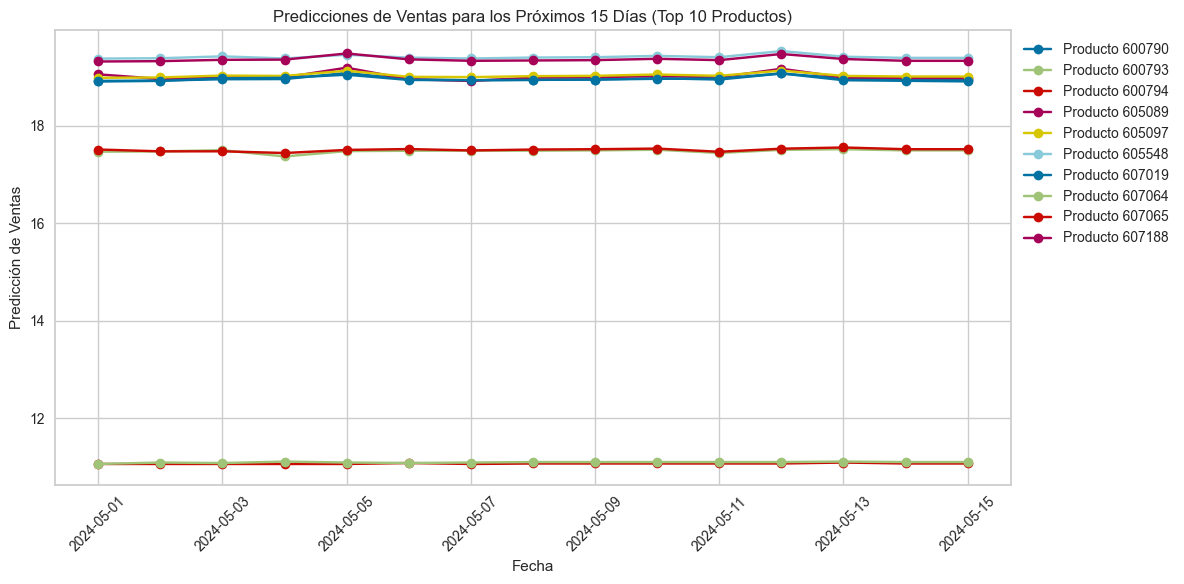

In [71]:
plt.figure(figsize=(12, 6))

# Graficar predicciones para un subconjunto de productos
top_products = predictions['PRDCODEXT'].unique()[:10]

for product_code in top_products:
    product_data = predictions[predictions['PRDCODEXT'] == product_code]
    plt.plot(product_data['MOVFEC'], product_data['prediction_label'], marker='o', linestyle='-', label=f'Producto {product_code}')

plt.xlabel('Fecha')
plt.ylabel('Predicción de Ventas')
plt.title('Predicciones de Ventas para los Próximos 15 Días (Top 10 Productos)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


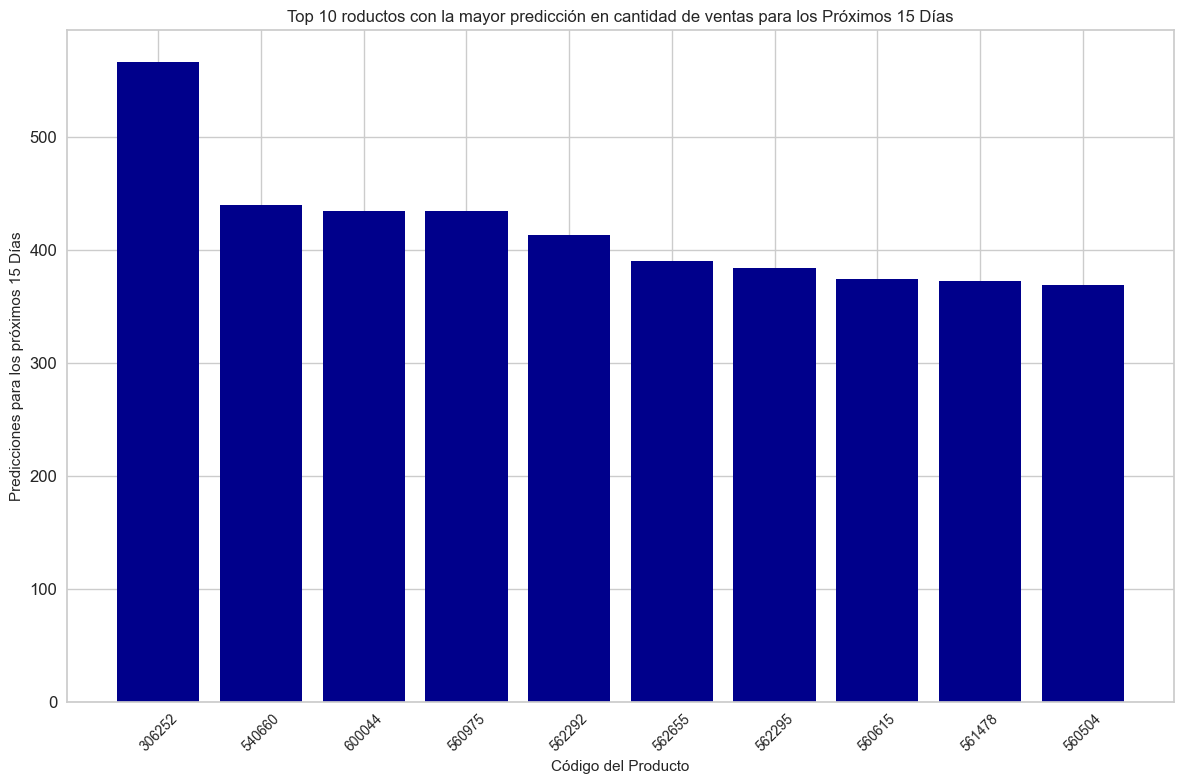

In [72]:
# Calcular la suma de las predicciones para los próximos 15 días por producto
sum_15_days = predictions.groupby('PRDCODEXT').apply(lambda df: df['prediction_label'].sum()).reset_index()
sum_15_days.columns = ['PRDCODEXT', 'suma_15_dias']

# Seleccionar los 10 productos con la mayor suma
top_10_products = sum_15_days.sort_values(by='suma_15_dias', ascending=False).head(10)

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear la gráfica de barras horizontales para los 10 productos principales
plt.bar(top_10_products['PRDCODEXT'].astype(str), top_10_products['suma_15_dias'], color='darkblue')

# Añadir etiquetas y título
plt.ylabel('Predicciones para los próximos 15 Días')
plt.xlabel('Código del Producto')
plt.title('Top 10 roductos con la mayor predicción en cantidad de ventas para los Próximos 15 Días')

# Ajustar el tamaño de la fuente de las etiquetas
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)

# Mejorar el espaciado
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [73]:
# Filtrar los productos por las categorías 216 y 217
productos_cat_216_217 = productos[productos['Cat'].isin([216, 217])]

# Mostrar los códigos de producto y las categorías
print("Códigos de producto y categorías para Cat 216 y 217:")
print(productos_cat_216_217[['Cod', 'Cat']])

# Filtrar las ventas para los productos de las categorías 216 y 217
ventas_cat_216_217 = ventas[ventas['PRDCODEXT'].isin(productos_cat_216_217['Cod'])]

# Preparar el DataFrame para la predicción
ventas_cat_216_217['MOVFEC'] = pd.to_datetime(ventas_cat_216_217['MOVFEC'], format='%Y-%m-%d', errors='coerce')

# Preparar los datos futuros para predicciones (similares al código anterior)
future_dates = pd.date_range(start=ventas_cat_216_217['MOVFEC'].max() + pd.Timedelta(days=1), periods=15, freq='D')
future_data = pd.DataFrame({
    'MOVFEC': future_dates,
    'PRDCODEXT': np.repeat(ventas_cat_216_217['PRDCODEXT'].unique(), len(future_dates) // len(ventas_cat_216_217['PRDCODEXT'].unique()) + 1)[:len(future_dates)],
    'dia_semana': future_dates.dayofweek,
    'mes': future_dates.month,
    'año': future_dates.year,
    'día_del_mes': future_dates.day
})

# Inicializar columnas necesarias con valores adecuados
columns_needed = [
    'MOVFEC', 'PRDCODEXT', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 
    'ventas_15_dias', 'promedio_15_dias', 'is_promo', 'ventas_15d', 'dia_semana', 
    'mes', 'año', 'día_del_mes', 'cluster', 'promo_cluster', 'cluster_2', 
    'cluster_3', 'cluster_4', 'cluster_5', 'ACPRCANTVEND'
]

# Calcular características necesarias
for prd in future_data['PRDCODEXT'].unique():
    prd_data = ventas_cat_216_217[ventas_cat_216_217['PRDCODEXT'] == prd].sort_values(by='MOVFEC').copy()
    prd_data['lag_1'] = prd_data['ACPRCANTVEND'].shift(1)
    prd_data['lag_7'] = prd_data['ACPRCANTVEND'].shift(7)
    prd_data['rolling_mean_7'] = prd_data['ACPRCANTVEND'].rolling(window=7).mean()
    prd_data['rolling_std_7'] = prd_data['ACPRCANTVEND'].rolling(window=7).std()
    prd_data['ventas_15_dias'] = prd_data['ACPRCANTVEND'].rolling(window=15).sum()
    prd_data['promedio_15_dias'] = prd_data['ACPRCANTVEND'].rolling(window=15).mean()

    for date in future_data['MOVFEC']:
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'lag_1'] = prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=1)]['ACPRCANTVEND'].values[0] if not prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=1)].empty else 0
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'lag_7'] = prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=7)]['ACPRCANTVEND'].values[0] if not prd_data[prd_data['MOVFEC'] == date - pd.Timedelta(days=7)].empty else 0
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'rolling_mean_7'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=7).mean().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 7 else 0
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'rolling_std_7'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=7).std().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 7 else 0
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'ventas_15_dias'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=15).sum().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 15 else 0
        future_data.loc[(future_data['PRDCODEXT'] == prd) & (future_data['MOVFEC'] == date), 'promedio_15_dias'] = prd_data[prd_data['MOVFEC'] < date]['ACPRCANTVEND'].rolling(window=15).mean().values[-1] if len(prd_data[prd_data['MOVFEC'] < date]) >= 15 else 0

# Asegurarse de que todas las columnas necesarias están presentes y ordenadas
future_data = future_data.reindex(columns=columns_needed).fillna(0)

# Verificar el DataFrame final antes de la predicción
print("DataFrame de datos futuros:")
print(future_data.head())
print(f"Forma del DataFrame de datos futuros: {future_data.shape}")

# Realizar la predicción usando el modelo cargado
try:
    predictions = predict_model(final_model, data=future_data)
    
    # Verificar que predictions no sea None
    if predictions is not None:
        print(f"Tamaño de predictions: {len(predictions)}")
        print(f"Primeras predicciones:")
        print(predictions.head())
    else:
        print("El método predict_model devolvió None")
except Exception as e:
    print(f"Error durante la predicción: {e}")


Códigos de producto y categorías para Cat 216 y 217:
         Cod  Cat
0     561699  216
1     561634  216
2     561694  216
3     561826  216
4     561891  216
...      ...  ...
2079  562769  216
2080  562771  216
2081  562772  216
2082  562774  216
2083  562775  216

[2084 rows x 2 columns]
DataFrame de datos futuros:
      MOVFEC  PRDCODEXT  lag_1  lag_7  rolling_mean_7  rolling_std_7  \
0 2024-05-01     600790    1.0    0.0        2.000000       2.236068   
1 2024-05-02     600793    0.0    0.0        1.428571       0.786796   
2 2024-05-03     600794    0.0    0.0        1.000000       0.000000   
3 2024-05-04     605089    0.0    0.0        2.714286       1.603567   
4 2024-05-05     605097    0.0    0.0        2.000000       1.527525   

   ventas_15_dias  promedio_15_dias  is_promo  ventas_15d  ...  mes   año  \
0            26.0          1.733333       0.0         0.0  ...    5  2024   
1            19.0          1.266667       0.0         0.0  ...    5  2024   
2            1

In [74]:
# Predicciones para Cat_216 y Cat_217
# Renombrar la columna 'Cod' en 'productos_cat_216_217' para hacer merge
productos_cat_216_217 = productos_cat_216_217.rename(columns={'Cod': 'PRDCODEXT'})

# Unir los DataFrames 'predictions' y 'productos_cat_216_217' por 'PRDCODEXT'
predictions_with_categories = pd.merge(predictions, productos_cat_216_217[['PRDCODEXT', 'Cat']], on='PRDCODEXT', how='left')

# Mostrar el DataFrame combinado con las categorías
(predictions_with_categories[['MOVFEC', 'PRDCODEXT', 'prediction_label', 'Cat']])

,MOVFEC,PRDCODEXT,prediction_label,Cat
0,2024-05-01,600790,11.009825,216
1,2024-05-02,600793,11.107284,216
2,2024-05-03,600794,11.058347,216
3,2024-05-04,605089,11.107284,216
4,2024-05-05,605097,11.117147,216
5,2024-05-06,605548,11.117477,216
6,2024-05-07,607019,11.137874,216
7,2024-05-08,607064,11.097752,216
8,2024-05-09,607065,11.137215,216
9,2024-05-10,607188,11.048833,216


In [76]:
# Filtra los productos de la categoría 217
productos_cat_217 = productos[productos['Cat'] == 217]
print("Productos de la categoría 217:")
print(productos_cat_217)

# Renombra la columna 'Cod' en 'productos' para hacer merge si es necesario
productos_cat_217 = productos_cat_217.rename(columns={'Cod': 'PRDCODEXT'})

# Filtra los códigos de producto para la categoría 217
codigos_cat_217 = productos_cat_217['PRDCODEXT'].unique()
print("Códigos de producto de la categoría 217 en predictions:")
print(codigos_cat_217)

# Verifica si hay códigos de la categoría 217 en predictions
predicciones_cat_217 = predictions[predictions['PRDCODEXT'].isin(codigos_cat_217)]
print("Predicciones para los productos de la categoría 217:")
print(predicciones_cat_217)

# Verifica el DataFrame combinado (predictions_with_categories) si existe
if 'predictions_with_categories' in globals():
    print("Distribución de categorías en predictions_with_categories:")
    print(predictions_with_categories['Cat'].value_counts())

    # Verifica algunas filas del DataFrame después de la fusión
    print("Primeras filas de predictions_with_categories:")
    print(predictions_with_categories.head())

    # Verifica los códigos de producto únicos después de la fusión
    print("Códigos de producto después de la fusión:")
    print(predictions_with_categories['PRDCODEXT'].unique())
else:
    print("El DataFrame 'predictions_with_categories' no está definido.")


Productos de la categoría 217:
         Cod  Status Hoy   Prov  Cat  Tipo Prov
12    561208           5  10214  217          1
21    561347           5  10214  217          1
25    561348           5  10214  217          1
32    560876           1  10214  217          1
33    560724           1  10214  217          1
...      ...         ...    ...  ...        ...
2074  543565           5  66169  217          1
2075  543564           5  66169  217          1
2076  542193           5  66169  217          1
2077  542194           5  66169  217          1
2078  542195           5  66169  217          1

[253 rows x 5 columns]
Códigos de producto de la categoría 217 en predictions:
[561208 561347 561348 560876 560724 560702 560703 560704 560714 560845
 560217 561917 561272 561271 560789 560656 560655 560732 560713 561353
 560706 560705 561563 561624 561628 561862 561508 562213 562264 562311
 562310 562666 562667 562157 584456 584457 561341 562246 601263 561259
 561145 561885 974020 562304 

In [77]:
# Lista de códigos de producto de la categoría 217
codigos_cat_217 = [
    561208, 561347, 561348, 560876, 560724, 560702, 560703, 560704, 560714,
    560845, 560217, 561917, 561272, 561271, 560789, 560656, 560655, 560732,
    560713, 561353, 560706, 560705, 561563, 561624, 561628, 561862, 561508,
    562213, 562264, 562311, 562310, 562666, 562667, 562157, 584456, 584457,
    561341, 562246, 601263, 561259, 561145, 561885, 974020, 562304, 560147,
    560145, 540001, 562715, 561369, 561130, 565607, 565608, 561502, 561501,
    561438, 562484, 561167, 561405, 561408, 562469, 560279, 562050, 561951,
    562333, 562429, 562485, 562486, 562552, 562551, 562953, 562935, 561495,
    561496, 562421, 604127, 604126, 561301, 560889, 561328, 561300, 562290,
    562291, 562170, 562897, 562898, 562171, 561186, 562294, 561639, 561733
]

# 1. Filtrar las predicciones para los códigos de producto de la categoría 217
predictions_with_categories = pd.merge(predictions, productos_cat_216_217[['PRDCODEXT', 'Cat']], on='PRDCODEXT', how='left')

# Filtrar solo para los códigos de categoría 217
predicciones_cat_217 = predictions_with_categories[predictions_with_categories['PRDCODEXT'].isin(codigos_cat_217)]

# Mostrar las predicciones para los productos de la categoría 217
print("Predicciones para los productos de la categoría 217:")
print(predicciones_cat_217[['MOVFEC', 'PRDCODEXT', 'prediction_label', 'Cat']])


Predicciones para los productos de la categoría 217:
Empty DataFrame
Columns: [MOVFEC, PRDCODEXT, prediction_label, Cat]
Index: []


In [78]:
# Datos del modelo
modelo_metrics = {
    'MAE': 0.1321,
    'MSE': 4.8463,
    'RMSE': 2.2014,
    'R2': 0.7200,
    'RMSLE': 0.0690,
    'MAPE': 0.0291
}

# Datos de predicciones
predicciones = pd.DataFrame({
    'PRDCODEXT': [561049, 561060, 561029, 561697, 600042, 590136, 601328, 600893, 601464, 600881],
    'Predicción': [19, 11, 17, 11, 17, 11, 11, 11, 18, 18]
})

# Datos históricos de ventas
ventas_historicas = pd.DataFrame({
    'PRDCODEXT': [561029, 561049, 561060, 561697, 590136, 600042, 600881, 600893, 601328, 601464],
    'ACPRCANTVEND': [32, 217, 209, 3, 3, 180, 1, 1, 1, 1]
})

# Unir las ventas históricas y las predicciones
merged_data = pd.merge(predicciones, ventas_historicas, on='PRDCODEXT', how='inner')

# Calcular el error absoluto promedio usando MAE del modelo
mae_model = modelo_metrics['MAE']
error_estimado_mae = mae_model * len(merged_data)
print(f"Error Estimado (basado en MAE del modelo): {error_estimado_mae:.4f}")

# Calcular el error cuadrático medio estimado usando RMSE del modelo
rmse_model = modelo_metrics['RMSE']
error_estimado_rmse = rmse_model * np.sqrt(len(merged_data))
print(f"Error Estimado (basado en RMSE del modelo): {error_estimado_rmse:.4f}")

# Calcular el error porcentual medio estimado usando MAPE del modelo
mape_model = modelo_metrics['MAPE']
mean_actual_sales = merged_data['ACPRCANTVEND'].mean()
error_estimado_mape = mean_actual_sales * mape_model * len(merged_data)
print(f"Error Estimado (basado en MAPE del modelo): {error_estimado_mape:.4f}")


Error Estimado (basado en MAE del modelo): 1.3210
Error Estimado (basado en RMSE del modelo): 6.9614
Error Estimado (basado en MAPE del modelo): 18.8568


In [79]:
# Datos del modelo
modelo_metrics = {
    'MAE': 0.1321,
    'RMSE': 2.2014,
    'MAPE': 0.0291
}

# Datos de predicciones
predicciones = pd.DataFrame({
    'PRDCODEXT': [561049, 561060, 561029, 561697, 600042, 590136, 601328, 600893, 601464, 600881],
    'Predicción': [19, 11, 17, 11, 17, 11, 11, 11, 18, 18]
})

# Calcular intervalos de error para cada predicción
predicciones['Error Estimado MAE Inferior'] = predicciones['Predicción'] - modelo_metrics['MAE']
predicciones['Error Estimado MAE Superior'] = predicciones['Predicción'] + modelo_metrics['MAE']

predicciones['Error Estimado RMSE Inferior'] = predicciones['Predicción'] - modelo_metrics['RMSE']
predicciones['Error Estimado RMSE Superior'] = predicciones['Predicción'] + modelo_metrics['RMSE']

predicciones['Error Estimado MAPE Inferior'] = predicciones['Predicción'] - (predicciones['Predicción'] * modelo_metrics['MAPE'])
predicciones['Error Estimado MAPE Superior'] = predicciones['Predicción'] + (predicciones['Predicción'] * modelo_metrics['MAPE'])

# Mostrar resultados
(predicciones)


,PRDCODEXT,Predicción,Error Estimado MAE Inferior,Error Estimado MAE Superior,Error Estimado RMSE Inferior,Error Estimado RMSE Superior,Error Estimado MAPE Inferior,Error Estimado MAPE Superior
0,561049,19,18.8679,19.1321,16.7986,21.2014,18.4471,19.5529
1,561060,11,10.8679,11.1321,8.7986,13.2014,10.6799,11.3201
2,561029,17,16.8679,17.1321,14.7986,19.2014,16.5053,17.4947
3,561697,11,10.8679,11.1321,8.7986,13.2014,10.6799,11.3201
4,600042,17,16.8679,17.1321,14.7986,19.2014,16.5053,17.4947
5,590136,11,10.8679,11.1321,8.7986,13.2014,10.6799,11.3201
6,601328,11,10.8679,11.1321,8.7986,13.2014,10.6799,11.3201
7,600893,11,10.8679,11.1321,8.7986,13.2014,10.6799,11.3201
8,601464,18,17.8679,18.1321,15.7986,20.2014,17.4762,18.5238
9,600881,18,17.8679,18.1321,15.7986,20.2014,17.4762,18.5238
